# Project Data Analysis

This notebook contains the analysis of project data for the Reddit place experiment.

We have computed several distributions, scatter plots and visualizations to better understant the dataset.

To run this notebook, the following files should be precomputed in the '.../data/' folder:

1) sorted_tile_placements_proj.csv : Tile updates with project information added. Format: 

#ts,user,x_coordinate,y_coordinate,color,pic_id,pixel,pixel_color

2) sorted_tile_placements_proj_den_freq.csv : Denoised version of the previous file using Frequent Pixel heuristic.

3) sorted_tile_placements_proj_den_freq.csv : Denoised version of same file based on figure created by users.

4) atlas_filtered.json : Filtered version of the place atlas

## Sections:

[Updates per Project](#Updates_per_Project)

[Colors and Pixels per Project (Original Data)](#Colors_and_Pixels_per_Project_Original)

[Colors and Pixels per Project (Denoised Data using Frequent Color)](#Colors_and_Pixels_per_Project_Denoised_Frequent)

[Colors and Pixels per Project (Denoised by Users)](#Colors_and_Pixels_per_Project_Denoised_Users)

[Pixels per Project](#Pixels_per_Project)

[Projects per User](#Projects_per_User)

[Users per Project](#Users_per_Project)

[Time per Project](#Time_per_Project)

In [1]:
import csv
import sys
import os
import math
import numpy as np
import numpy.linalg as npla
import scipy
from scipy import sparse
from scipy import linalg
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.mlab as mlab
from mpl_toolkits.mplot3d import axes3d
import operator

In [2]:
import sys
sys.path.append("../Python_code") # go to parent dir
from reddit import *
from canvas_vis import *
from project_data_analysis import *

# Setting up Variables

In [91]:
#Run this before anything else!

input_file_proj = "../data/sorted_tile_placements_proj.csv"
input_file_proj_den_freq = "../data/tile_placements_denoised_freq_proj.csv"
input_file_proj_den_users = "../data/tile_placements_denoised_users_proj.csv"
js_filename = "../data/atlas_filtered.json"

#Projects to remove 777, 1921 (whole canvas), 1240, 1516 (1 pixel), 1319 (very incomplete)
#1169, 42 (repeated American Flag, 1122), 1066 (repeated blue corner 67), 
#1757 (repeated the far left side 736), 1824 (climber's head, too small)
#320 (repeated kenkistan/rainbow flat 3311)
#351 (repeated erase the place 1297)
#1046, 1073 (repeated channel orange 958)
#998, 1870 (repeated darth plagueis the wise 75)
#1383, 1493, 1823, 1818, 645, 1640 (Very small)
#1811, 1925, 1927, 704, 1085, 1308, 1378, 1412, 1418, 1428, 1455, 1482, 1512, 1548, 1589, 
#1614, 1790, 939, 1263, 1383, 1155, 1524, 129, 1595, 1254, 1528, 1529, 1578, 1616, 1721 (Covered)
projects_to_remove = {'777', '1921', '1169', '42', '1066', '1757', '1824', '320', '998', '1870', '1811',\
                     '1925', '1927', '704', '1085', '1308', '1378', '1412', '1418', '1428', '1455', '1482',\
                      '1512', '1548', '1589', '1614', '1790', '1319', '939', '1263', '1383', '1155', '1761', 
                     '1524', '351', '129', '1046', '1073', '1595', '1254', '1528', '1529', '1578', '1616',\
                     '1721'}

locations = store_locations(js_filename)

names, descriptions = read_picture_names_and_descriptions(js_filename)

<a id='Updates_per_Project'></a>
# Updates per Project

In [31]:
#Computing updates per project
updates_per_proj, total_updates = updates_per_project(input_file_proj, projects_to_remove)

print("total updates:", total_updates)

total updates: 28393459


In [32]:
sorted_up_proj = sorted(updates_per_proj.items(), key=operator.itemgetter(1), reverse=True)

#Top-10
for i in range(10):
    proj = sorted_up_proj[i][0]
    up = sorted_up_proj[i][1]
    name = names[int(proj)]
    desc = descriptions[int(proj)]
    
    print("#", i, ", project: ", name, ", updates: ", up, ", \ndesc: ", desc, "\n")

# 0 , project:  Rainbow Road , updates:  1098333 , 
desc:  One of the first projects on r/place, and also one of the largest. It integrates itself with many other artworks. 

# 1 , project:  USA / Canvas Center , updates:  693586 , 
desc:  The center of the canvas was a controversial and disputed part of r/place. It began to be filled with numerous randomly placed pixels. As organized groups began creating masterpieces, the center began a white void, part of r/erase. As the original (dark) Void began to eat the center of the canvas, the USA Flag began to take shape covering a branch from the void. The flag took over the white void and a few projects including a smiley and a tree. Then the void reappeared in place and with other people erased most of the flag as RainbowRoad expanded where the flag was. Ireland saw an opportunity  and decided to expand as well. A net of yellow lines appeared and took over the void and r/AmericanFlaginPlace with help of r/TheDonald and other redditors, he

In [33]:
#Bottom-10

for i in range(1,11):
    proj = sorted_up_proj[-i][0]
    up = sorted_up_proj[-i][1]
    name = names[int(proj)]
    desc = descriptions[int(proj)]
    
    print("#", i, ", project: ", name, ", updates: ", up, ", \ndescription: ", desc, "\n")

# 1 , project:  Smiley Face , updates:  84 , 
description:  A universal symbol of happiness rendered on a small scale for bite sized fun. 

# 2 , project:  Tiny danish flag , updates:  112 , 
description:  denmark is a samll nation in the nothern part of europe 

# 3 , project:  The R , updates:  121 , 
description:  The R of the sub r/The_R 

# 4 , project:  Red P , updates:  126 , 
description:  Seeing the whole work was an amazing piece of modern art, I really wanted to be a part of it. I decided to find a small unused spot and put my initial there. The void and erase factions were savage and had wiped two previous efforts and a larger piece of art I was helping maintain, so I found a spot and used a script running on 2 PC's to maintain my small part of the artwork until place ended, which happened while I was sleeping. 

# 5 , project:  Italy heart , updates:  128 , 
description:  A random heart or a symbol of cooperation between Scott Pilgrim and Italy? 

# 6 , project:  Amaura , 

In [34]:
#AVG

print("AVG = ", np.mean(np.array(list(updates_per_proj.values()))))

AVG =  15314.702804746494


In [35]:
#STD

print("STD = ", np.std(np.array(list(updates_per_proj.values()))))

STD =  48072.85718265574


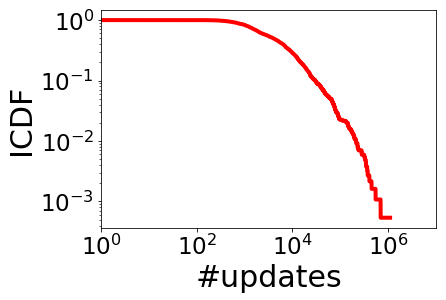

In [38]:
#Inverse cumulative density funcition

def plot_updates_per_project_icdf(count, output_file_name):
    plt.clf()
    ax = plt.subplot(111)
    ax.loglog(range(len(count)), count, color="red", linewidth=4)
    ax.set_ylabel('ICDF', fontsize=30)
    ax.set_xlabel('#updates', fontsize=30)
    ax.tick_params(labelsize=23)
    ax.set_xlim(1,10000000)
    plt.savefig(output_file_name, dpi=300, bbox_inches='tight')
    
#Computing ICDF
count = icdf(updates_per_proj)
    
plot_updates_per_project_icdf(count, "../plots/plot_updates_per_project_icdf.svg")

<a id='Colors_and_Pixels_per_Project_Original'></a>
# Colors and Pixels per Project (Original Data)

In [39]:
# Computing colors per project and entropies
#Only pixels (final) are considered.
colors_per_proj = colors_per_project(input_file_proj, projects_to_remove)
entropy_per_proj = entropy_per_project(colors_per_proj)

In [40]:
num_colors_per_proj = {}

for proj in colors_per_proj:
    num_colors_per_proj[proj] = np.count_nonzero(colors_per_proj[proj])

In [41]:
sorted_color_proj = sorted(num_colors_per_proj.items(), key=operator.itemgetter(1), reverse=True)

#Top-10
for i in range(10):
    proj = sorted_color_proj[i][0]
    colors = sorted_color_proj[i][1]
    name = names[int(proj)]
    desc = descriptions[int(proj)]
    
    print("#", i, ", project: ", name, ", colors: ", colors, ", \ndesc: ", desc, "\n")

# 0 , project:  Mona Lisa , colors:  16 , 
desc:  In order to prove the point that reddit users are a cultured bunch, a group of them set out to recreate Leonardo da Vinci's Mona Lisa. 

# 1 , project:  Rainbow Road , colors:  16 , 
desc:  One of the first projects on r/place, and also one of the largest. It integrates itself with many other artworks. 

# 2 , project:  R.I.P. Steve Irwin , colors:  16 , 
desc:  A tribute to the late Crocodile Hunter Steve Irwin, courtesy of /r/Straya. Unfortunately, Steve was vandalized a bit before the final frame of /r/place - as a result, he's got an odd smiley line where his face should be and his date of death is wrong. It should be 4/9/06. 

# 3 , project:  Australian Self Image  , colors:  16 , 
desc:  The best self image of any country in the world. Contains the man himself, Steve Irwin, Vegemite, a Koala, Spider, Snake, and naturally, a boxing Kangaroo. With the country's national collective greeting: "G'Day Cunts" 

# 4 , project:  Rainbow Ro

In [43]:
#Bottom-10

for i in range(1,11):
    proj = sorted_color_proj[-i][0]
    colors = sorted_color_proj[-i][1]
    name = names[int(proj)]
    desc = descriptions[int(proj)]
    
    print("#", i, ", project: ", name, ", colors: ", colors, ", \ndesc: ", desc, "\n")

# 1 , project:  (0,0) , colors:  1 , 
desc:  The top left corner of /r/place. Warred over by the purple corner, the runescape people, and various others 

# 2 , project:  Gold Codfish , colors:  2 , 
desc:  The /r/portugal equivalent of reddit gold. Given to topics and posts of high quality in the subreddit (mod flair) 

# 3 , project:  Canadian Flag , colors:  2 , 
desc:  The flag of Canada. 

# 4 , project:  Numberphile , colors:  2 , 
desc:  One of the many Youtube channels Brady Haran runs. 

# 5 , project:  Numberphile Logo , colors:  2 , 
desc:  YouTube channel by Brady Haran focused on numbers and mathematics. 

# 6 , project:  Seventeen , colors:  2 , 
desc:  SEVENTEEN, or SVT, is a South Korean boy idol group that debuted in 2015 with Pledis Entertainment. Their members are divided into three sub-units. Their official fan club is known as Carat, with a jewel icon.  It is represented here in their fandom colors. 

# 7 , project:  Auburn University , colors:  2 , 
desc:  Auburn 

In [44]:
#AVG

print("AVG = ", np.mean(np.array(list(num_colors_per_proj.values()))))

AVG =  7.119201725997843


In [45]:
#STD

print("STD = ", np.std(np.array(list(num_colors_per_proj.values()))))

STD =  3.74689057843588


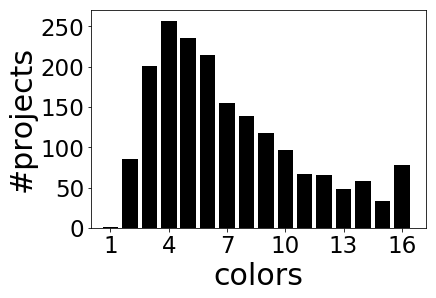

In [46]:
%matplotlib inline
def plot_colors_per_project_hst(count, output_file_name):
    plt.clf()

    ax = plt.subplot(111)
    ax.bar(np.arange(count.shape[0]), count, color="black", linewidth=4)
    ax.set_ylabel('#projects', fontsize=30)
    ax.set_xlabel('colors', fontsize=30)
    ax.tick_params(labelsize=23)
    ax.set_xlim(0,)
    ax.set_xticks(np.arange(1,17, 3))
    ax.set_yticks(np.arange(0, 300, 50))
    plt.savefig(output_file_name, dpi=300, bbox_inches='tight')

count = np.zeros(17)

for c in num_colors_per_proj.values():
    count[c] = count[c] + 1
    
plot_colors_per_project_hst(count, "../plots/plot_colors_project_hist.svg")

In [47]:
sorted_ent_proj = sorted(entropy_per_proj.items(), key=operator.itemgetter(1), reverse=True)

#Top-10
for i in range(10):
    proj = sorted_ent_proj[i][0]
    ent = sorted_ent_proj[i][1]
    name = names[int(proj)]
    desc = descriptions[int(proj)]
    
    print("#", i, ", project: ", name, ", entropy: ", ent, ", \ndesc: ", desc, "\n")

# 0 , project:  Unfinished Place World Congress Banner , entropy:  2.571020628332455 , 
desc:  Now known as Reddit World Congress was a Discord server used by many r/place diplomats to make peace treaties with other factions. The server had as many as 2.3k users at the time of r/place going down. The banner was never finished due to the project starting too late and small number of people helping to build it. https://puu.sh/v7YrL/135381821e.png 

# 1 , project:  Rainbow Road , entropy:  2.56657965607805 , 
desc:  One of the first projects on r/place, and also one of the largest. It integrates itself with many other artworks. 

# 2 , project:  Rainbow Road Core , entropy:  2.5664631259505044 , 
desc:  One of the earliest major faction on Place. They spread from here originally. After a while they began allowing others to build art in their space, making peace treaties and agreements with other factions 

# 3 , project:  Slushii , entropy:  2.5534266565333072 , 
desc:  Slush it up 

# 4 

In [48]:
#Bottom-10

for i in range(1,11):
    proj = sorted_ent_proj[-i][0]
    ent = sorted_ent_proj[-i][1]
    name = names[int(proj)]
    desc = descriptions[int(proj)]
    
    print("#", i, ", project: ", name, ", entropy: ", ent, ", \ndesc: ", desc, "\n")

# 1 , project:  (0,0) , entropy:  0.0 , 
desc:  The top left corner of /r/place. Warred over by the purple corner, the runescape people, and various others 

# 2 , project:  The Void , entropy:  0.3101432858015195 , 
desc:  The final core of the Void, with half of the Void's forces defending the core that destroyed Mexico, The Mona Lisa's face, The Oilers, and multiple other pixelart structures, and the other half of the Void's forces defending the Kekistan flag to the South. 

# 3 , project:  Frank Ocean - Channel Orange , entropy:  0.31716411734718 , 
desc:  Frank's 2012 album, Channel Orange. 

# 4 , project:  pr0gramm , entropy:  0.3307120958088891 , 
desc:  Icon of the german imageboard pr0gramm.com 

# 5 , project:  Erase The Place , entropy:  0.374161179110607 , 
desc:  The Purity Triangle represents what was once the grand white circle, and formed when EraseThePlace started making alliances and wasn't focused on cleaning the entire canvas. 

# 6 , project:  Faction Logo , entro

In [49]:
#AVG

print("AVG = ", np.mean(np.array(list(entropy_per_proj.values()))))

AVG =  1.311790331527323


In [50]:
#STD

print("STD = ", np.std(np.array(list(entropy_per_proj.values()))))

STD =  0.4036649586729715


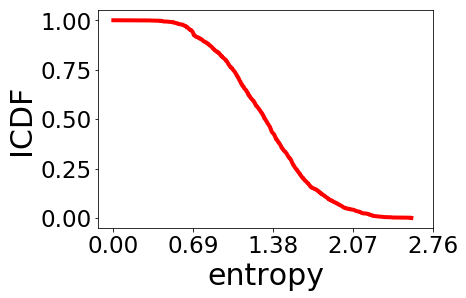

In [51]:
%matplotlib inline
def plot_color_entropies_per_project_icdf(entropy, count, output_file_name):
    plt.clf()

    ax = plt.subplot(111)
    ax.plot(entropy, count, color="red", linewidth=4)
    ax.set_ylabel('ICDF', fontsize=30)
    ax.set_xlabel('entropy', fontsize=30)
    ax.tick_params(labelsize=23)
    ax.set_xticks(np.arange(0,math.exp(1)+.1, .69))
    ax.set_yticks(np.arange(0, 1.1, .25))
    plt.savefig(output_file_name, dpi=300, bbox_inches='tight')

#Computing ICDF
entropy = sorted(list(entropy_per_proj.values()))

count = np.arange(len(entropy)+1)[len(entropy)+1:0:-1]
count = count / count[0]

plot_color_entropies_per_project_icdf(entropy, count, "../plots/plot_color_entropies_icdf.svg")

<a id='Colors_and_Pixels_per_Project_Denoised_Frequent'></a>
# Colors and Pixels per Project (Denoised Data using Frequent Color)

In [79]:
# Computing colors per project and entropies
#Only pixels (final) are considered.

colors_per_proj_den_freq = colors_per_project(input_file_proj_den_freq, projects_to_remove)
entropy_per_proj_den_freq = entropy_per_project(colors_per_proj_den_freq)

In [80]:
num_colors_per_proj_den_freq = {}

for proj in colors_per_proj_den_freq:
    num_colors_per_proj_den_freq[proj] = np.count_nonzero(colors_per_proj_den_freq[proj])

In [81]:
sorted_color_proj = sorted(num_colors_per_proj_den_freq.items(), key=operator.itemgetter(1), reverse=True)

#Top-10
for i in range(10):
    proj = sorted_color_proj[i][0]
    colors = sorted_color_proj[i][1]
    name = names[int(proj)]
    desc = descriptions[int(proj)]
    
    print("#", i, ", project: ", name, ", colors: ", colors, ", \ndesc: ", desc, "\n")

# 0 , project:  Smash Bros , colors:  16 , 
desc:  The Smash Bros canvas featuring memes popular from within the community of Super Smash Bros, a series of crossover fighting games published by Nintendo, as well as some of our favorite characters. #Kreygasm 

# 1 , project:  Touhou Hijack , colors:  16 , 
desc:  Four characters and five items from the "Touhou" series of bullet hell shooter video games; including the name of the series' creator, ZUN. 

# 2 , project:  Rocket League , colors:  16 , 
desc:  Rocket League is a vehicular soccer video game developed and published by Psyonix. 

# 3 , project:  Portugal , colors:  16 , 
desc:  Includes several Portuguese traditions, achievements and obviously memes. All done with lots of love and dedication by Portuguese redditors who loved this experience. 

# 4 , project:  Hearts , colors:  16 , 
desc:  What started with a few red hearts quickly became over one hundred hearts bearing the colors of flags and other things. 

# 5 , project:  Ch

In [82]:
#Bottom-10

for i in range(1,11):
    proj = sorted_color_proj[-i][0]
    colors = sorted_color_proj[-i][1]
    name = names[int(proj)]
    desc = descriptions[int(proj)]
    
    print("#", i, ", project: ", name, ", colors: ", colors, ", \ndesc: ", desc, "\n")

# 1 , project:  (0,0) , colors:  1 , 
desc:  The top left corner of /r/place. Warred over by the purple corner, the runescape people, and various others 

# 2 , project:  Bitcoin , colors:  2 , 
desc:  The second, smaller drawing on /r/place for the cryptocurrency, Bitcoin 

# 3 , project:  Borussia Dortmund , colors:  2 , 
desc:  The badge of the German Bundesliga team Borussia Dortmund. 

# 4 , project:  Borussia Dortmund , colors:  2 , 
desc:  German soccer club. 

# 5 , project:  Borrusia Dortmund , colors:  2 , 
desc:  One of the biggest German football club based in Dortmund.  

# 6 , project:  Borussia Dortmund , colors:  2 , 
desc:  A German Football club based in DOrtmund. It's the second largest sports club by membership in Germany 

# 7 , project:  Borussia Dortmund Logo , colors:  2 , 
desc:  Borussia Dortmund is one of the most popular soccer teams in the German Bundesliga, currently ranked in 4th place. 

# 8 , project:  Borussia Dortmund , colors:  2 , 
desc:  Logo of Bo

In [83]:
#AVG

print("AVG = ", np.mean(np.array(list(num_colors_per_proj_den_freq.values()))))

AVG =  6.533441208198489


In [84]:
#STD

print("STD = ", np.std(np.array(list(num_colors_per_proj_den_freq.values()))))

STD =  3.429158759489576


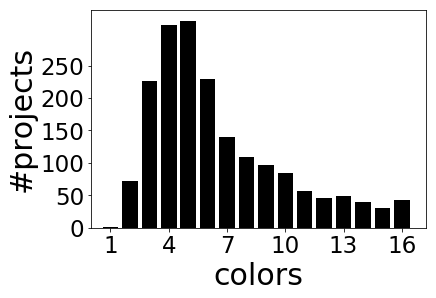

In [85]:
%matplotlib inline
def plot_colors_per_project_hst(count, output_file_name):
    plt.clf()

    ax = plt.subplot(111)
    ax.bar(np.arange(count.shape[0]), count, color="black", linewidth=4)
    ax.set_ylabel('#projects', fontsize=30)
    ax.set_xlabel('colors', fontsize=30)
    ax.tick_params(labelsize=23)
    ax.set_xlim(0,)
    ax.set_xticks(np.arange(1,17, 3))
    ax.set_yticks(np.arange(0, 300, 50))
    plt.savefig(output_file_name, dpi=300, bbox_inches='tight')

count = np.zeros(17)

for c in num_colors_per_proj_den_freq.values():
    count[c] = count[c] + 1
    
plot_colors_per_project_hst(count, "../plots/plot_colors_project_den_freq_hist.svg")

In [86]:
sorted_ent_proj = sorted(entropy_per_proj_den_freq.items(), key=operator.itemgetter(1), reverse=True)

#Top-10
for i in range(10):
    proj = sorted_ent_proj[i][0]
    ent = sorted_ent_proj[i][1]
    name = names[int(proj)]
    desc = descriptions[int(proj)]
    
    print("#", i, ", project: ", name, ", entropy: ", ent, ", \ndesc: ", desc, "\n")

# 0 , project:  Rainbow Road Core , entropy:  2.595885435797922 , 
desc:  One of the earliest major faction on Place. They spread from here originally. After a while they began allowing others to build art in their space, making peace treaties and agreements with other factions 

# 1 , project:  Slushii , entropy:  2.5441924542151226 , 
desc:  Slush it up 

# 2 , project:  Rainbow Road , entropy:  2.5290360094831352 , 
desc:  One of the first projects on r/place, and also one of the largest. It integrates itself with many other artworks. 

# 3 , project:  Unfinished Place World Congress Banner , entropy:  2.5173469467128946 , 
desc:  Now known as Reddit World Congress was a Discord server used by many r/place diplomats to make peace treaties with other factions. The server had as many as 2.3k users at the time of r/place going down. The banner was never finished due to the project starting too late and small number of people helping to build it. https://puu.sh/v7YrL/135381821e.png 

# 

In [87]:
#Bottom-10

for i in range(1,11):
    proj = sorted_ent_proj[-i][0]
    ent = sorted_ent_proj[-i][1]
    name = names[int(proj)]
    desc = descriptions[int(proj)]
    
    print("#", i, ", project: ", name, ", entropy: ", ent, ", \ndesc: ", desc, "\n")

# 1 , project:  (0,0) , entropy:  0.0 , 
desc:  The top left corner of /r/place. Warred over by the purple corner, the runescape people, and various others 

# 2 , project:  William Glitchspeare , entropy:  0.027479653339852462 , 
desc:  William Glitchspeare is an attempt by a fictional race within the game Starbound called The Glitch to reflect the personality of William Shakespeare in the form of their own civilization. 

# 3 , project:  Planetside's Attempted Invasion , entropy:  0.07664880077618422 , 
desc:  Planetside tried to recreate part of their logo here. Planetside managed to turn the corner grey. However, after much fighting Greenlattice overwhelmed and stomped out the invasion.  

# 4 , project:  The Void , entropy:  0.09037753732553422 , 
desc:  The final core of the Void, with half of the Void's forces defending the core that destroyed Mexico, The Mona Lisa's face, The Oilers, and multiple other pixelart structures, and the other half of the Void's forces defending the K

In [88]:
#AVG

print("AVG = ", np.mean(np.array(list(entropy_per_proj_den_freq.values()))))

AVG =  1.2692248752467452


In [89]:
#STD

print("STD = ", np.std(np.array(list(entropy_per_proj_den_freq.values()))))

STD =  0.3943684202083034


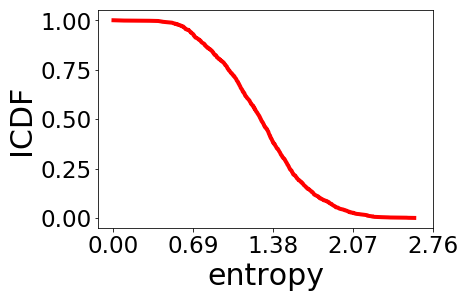

In [90]:
%matplotlib inline
def plot_color_entropies_per_project_icdf(entropy, count, output_file_name):
    plt.clf()

    ax = plt.subplot(111)
    ax.plot(entropy, count, color="red", linewidth=4)
    ax.set_ylabel('ICDF', fontsize=30)
    ax.set_xlabel('entropy', fontsize=30)
    ax.tick_params(labelsize=23)
    ax.set_xticks(np.arange(0,math.exp(1)+.1, .69))
    ax.set_yticks(np.arange(0, 1.1, .25))
    plt.savefig(output_file_name, dpi=300, bbox_inches='tight')

#Computing ICDF
entropy = sorted(list(entropy_per_proj_den_freq.values()))

count = np.arange(len(entropy)+1)[len(entropy)+1:0:-1]
count = count / count[0]

plot_color_entropies_per_project_icdf(entropy, count, "../plots/plot_color_entropies_den_freq_icdf.svg")

<a id='Colors_and_Pixels_per_Project_Denoised_Users'></a>
# Colors and Pixels per Project (Denoised Data using Canvas Denoised by Users)

In [92]:
# Computing colors per project and entropies
#Only pixels (final) are considered.
colors_per_proj_den_users = colors_per_project(input_file_proj_den_users, projects_to_remove)
entropy_per_proj_den_users = entropy_per_project(colors_per_proj_den_users)

In [93]:
num_colors_per_proj_den_users = {}

for proj in colors_per_proj_den_users:
    num_colors_per_proj_den_users[proj] = np.count_nonzero(colors_per_proj_den_users[proj])

In [94]:
sorted_color_proj = sorted(num_colors_per_proj_den_users.items(), key=operator.itemgetter(1), reverse=True)

#Top-10
for i in range(10):
    proj = sorted_color_proj[i][0]
    colors = sorted_color_proj[i][1]
    name = names[int(proj)]
    desc = descriptions[int(proj)]
    
    print("#", i, ", project: ", name, ", colors: ", colors, ", \ndesc: ", desc, "\n")

# 0 , project:  Entire Dutch Area , colors:  16 , 
desc:  Complete area built by Dutch subreddits 

# 1 , project:  Dutch Anthem and Royalty , colors:  16 , 
desc:  First part of the Dutch Anthem and their King and Queen, Willem & Maxima 

# 2 , project:  Rainbow Road , colors:  16 , 
desc:  One of the first projects on r/place, and also one of the largest. It integrates itself with many other artworks. 

# 3 , project:  Pharah from Overwatch , colors:  16 , 
desc:  Pharah is one of the playable characters in Overwatch, a team-based multiplayer first-person shooter video game developed and published by Blizzard Entertainment. 

# 4 , project:  CAPTHA , colors:  16 , 
desc:  TO SHOW THE WORLD THAT ONLY HUMANS WERE INVOLVED IN DRAWING THIS MASTERPIECE R/TOTALLYNOTROBOTS STARTED TO DRAW A RECAPTCHA 

# 5 , project:  ReCaptcha , colors:  16 , 
desc:  This block was planned to contain a picture of a ReCaptcha, to refer to the high amount of script usage in /r/place. However, this project wa

In [95]:
#Bottom-10

for i in range(1,11):
    proj = sorted_color_proj[-i][0]
    colors = sorted_color_proj[-i][1]
    name = names[int(proj)]
    desc = descriptions[int(proj)]
    
    print("#", i, ", project: ", name, ", colors: ", colors, ", \ndesc: ", desc, "\n")

# 1 , project:  Imgur logo , colors:  1 , 
desc:  It is very small 

# 2 , project:  Remnants of the /r/PictureGame Kiwi , colors:  1 , 
desc:  The original /r/PictureGame Kiwi was located here. Its remnants such as the beak /r/PICT and the PictureFrame(the snoo) are still visible. 

# 3 , project:  Amaura , colors:  1 , 
desc:  The head of the Generation 6 Fossil Pokémon Amaura. The body was covered up by surrounding art. 

# 4 , project:  (Former) Tiny Trump , colors:  1 , 
desc:  Early on in /r/place, the Donald Trump subreddit made a tiny Trump picture.  Shortly after construction, it got vandalized heavily with random pixels by the rest of reddit until it was finally abandoned. 

# 5 , project:  The Donald's Head , colors:  1 , 
desc:  /r/The_Donald encouraged it's members to contribute to a likeness of President Trump wearing a suit, a red tie and a red ball cap. Other /r/place users worked against that effort. All that's left now is a little orange hair, some yellow face, and th

In [96]:
#AVG

print("AVG = ", np.mean(np.array(list(num_colors_per_proj_den_users.values()))))

AVG =  6.2238403451995685


In [97]:
#STD

print("STD = ", np.std(np.array(list(num_colors_per_proj_den_users.values()))))

STD =  3.522780407540763


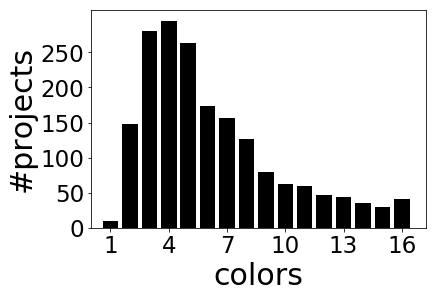

In [98]:
%matplotlib inline
def plot_colors_per_project_hst(count, output_file_name):
    plt.clf()

    ax = plt.subplot(111)
    ax.bar(np.arange(count.shape[0]), count, color="black", linewidth=4)
    ax.set_ylabel('#projects', fontsize=30)
    ax.set_xlabel('colors', fontsize=30)
    ax.tick_params(labelsize=23)
    ax.set_xlim(0,)
    ax.set_xticks(np.arange(1,17, 3))
    ax.set_yticks(np.arange(0, 300, 50))
    plt.savefig(output_file_name, dpi=300, bbox_inches='tight')

count = np.zeros(17)

for c in num_colors_per_proj_den_users.values():
    count[c] = count[c] + 1
    
plot_colors_per_project_hst(count, "../plots/plot_colors_project_den_users_hist.svg")

In [99]:
sorted_ent_proj = sorted(entropy_per_proj_den_users.items(), key=operator.itemgetter(1), reverse=True)

#Top-10
for i in range(10):
    proj = sorted_ent_proj[i][0]
    ent = sorted_ent_proj[i][1]
    name = names[int(proj)]
    desc = descriptions[int(proj)]
    
    print("#", i, ", project: ", name, ", entropy: ", ent, ", \ndesc: ", desc, "\n")

# 0 , project:  Rainbow Road Core , entropy:  2.5783186576151724 , 
desc:  One of the earliest major faction on Place. They spread from here originally. After a while they began allowing others to build art in their space, making peace treaties and agreements with other factions 

# 1 , project:  Rainbow Road , entropy:  2.5673212602349476 , 
desc:  One of the first projects on r/place, and also one of the largest. It integrates itself with many other artworks. 

# 2 , project:  Slushii , entropy:  2.5193511459524096 , 
desc:  Slush it up 

# 3 , project:  The Flag of Mexico , entropy:  2.480593659684477 , 
desc:  This is an attempt at creating a Mexican flag. Unfortunately, it was overtaken by other projects. 

# 4 , project:  Portal , entropy:  2.4765859036777584 , 
desc:  A portal from the game Portal by Valve. This portal and its matching orange end was drawn by /r/ainbowroad to protect a Waldo drawing from being overrun by the rainbow. The orange portal and Waldo are now mostly go

In [100]:
#Bottom-10

for i in range(1,11):
    proj = sorted_ent_proj[-i][0]
    ent = sorted_ent_proj[-i][1]
    name = names[int(proj)]
    desc = descriptions[int(proj)]
    
    print("#", i, ", project: ", name, ", entropy: ", ent, ", \ndesc: ", desc, "\n")

# 1 , project:  Imgur logo , entropy:  0.0 , 
desc:  It is very small 

# 2 , project:  Remnants of the /r/PictureGame Kiwi , entropy:  0.0 , 
desc:  The original /r/PictureGame Kiwi was located here. Its remnants such as the beak /r/PICT and the PictureFrame(the snoo) are still visible. 

# 3 , project:  Amaura , entropy:  0.0 , 
desc:  The head of the Generation 6 Fossil Pokémon Amaura. The body was covered up by surrounding art. 

# 4 , project:  (Former) Tiny Trump , entropy:  0.0 , 
desc:  Early on in /r/place, the Donald Trump subreddit made a tiny Trump picture.  Shortly after construction, it got vandalized heavily with random pixels by the rest of reddit until it was finally abandoned. 

# 5 , project:  The Donald's Head , entropy:  0.0 , 
desc:  /r/The_Donald encouraged it's members to contribute to a likeness of President Trump wearing a suit, a red tie and a red ball cap. Other /r/place users worked against that effort. All that's left now is a little orange hair, some yell

In [101]:
#AVG

print("AVG = ", np.mean(np.array(list(entropy_per_proj_den_users.values()))))

AVG =  1.2686344219019232


In [102]:
#STD

print("STD = ", np.std(np.array(list(entropy_per_proj_den_users.values()))))

STD =  0.42230910443998987


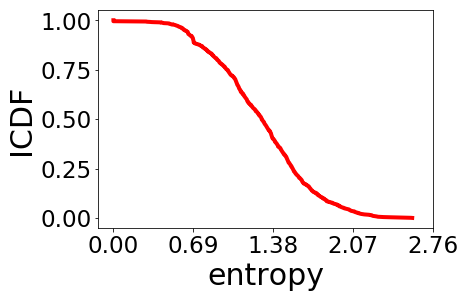

In [103]:
%matplotlib inline
def plot_color_entropies_per_project_icdf(entropy, count, output_file_name):
    plt.clf()

    ax = plt.subplot(111)
    ax.plot(entropy, count, color="red", linewidth=4)
    ax.set_ylabel('ICDF', fontsize=30)
    ax.set_xlabel('entropy', fontsize=30)
    ax.tick_params(labelsize=23)
    ax.set_xticks(np.arange(0,math.exp(1)+.1, .69))
    ax.set_yticks(np.arange(0, 1.1, .25))
    plt.savefig(output_file_name, dpi=300, bbox_inches='tight')

#Computing ICDF
entropy = sorted(list(entropy_per_proj_den_users.values()))

count = np.arange(len(entropy)+1)[len(entropy)+1:0:-1]
count = count / count[0]

plot_color_entropies_per_project_icdf(entropy, count, "../plots/plot_color_entropies_den_users_icdf.svg")

<a id='Pixels_per_Project'></a>
# Pixels per Project

In [12]:
# Pixels per project
pixels_per_proj = pixels_per_project(input_file_proj, projects_to_remove)

['1491176957000', 'Cs11POk9JmyE4d5am5fD+RXt+c0=', '917', '418', '3', '645', '1', '1']
['1491195381000', '4L/0cnbwKDBBDC8bhOMAvpM5jOc=', '915', '418', '3', '645', '1', '1']
['1491200042000', '/kPAUN24JccRjJ2drYWw2xxcobY=', '917', '419', '10', '645', '1', '1']
['1491215883000', '9/AxprT0lwT01lSBRF7m6Fbz/Dw=', '915', '417', '10', '645', '1', '1']
['1491235070000', '+X6wFHM1PPqs29j1qaVTSjVn9oY=', '917', '420', '7', '645', '1', '1']
['1491235392000', '+X6wFHM1PPqs29j1qaVTSjVn9oY=', '917', '421', '10', '645', '1', '1']
['1491235728000', '+X6wFHM1PPqs29j1qaVTSjVn9oY=', '916', '418', '0', '645', '1', '1']
['1491236033000', '+X6wFHM1PPqs29j1qaVTSjVn9oY=', '916', '419', '10', '645', '1', '1']
['1491236400000', '+X6wFHM1PPqs29j1qaVTSjVn9oY=', '916', '420', '7', '645', '1', '1']
['1491236768000', '+X6wFHM1PPqs29j1qaVTSjVn9oY=', '916', '421', '10', '645', '1', '1']
['1491237125000', '+X6wFHM1PPqs29j1qaVTSjVn9oY=', '916', '417', '10', '645', '1', '1']
['1491237428000', '+X6wFHM1PPqs29j1qaVTSjVn9oY='

In [13]:
sorted_pixel_proj = sorted(pixels_per_proj.items(), key=operator.itemgetter(1), reverse=True)

#Top-10
for i in range(10):
    proj = sorted_pixel_proj[i][0]
    pix = sorted_pixel_proj[i][1]
    name = names[int(proj)]
    desc = descriptions[int(proj)]
    
    print("#", i, ", project: ", name, ", pixels: ", pix, ", \ndesc: ", desc, "\n")

# 0 , project:  Rainbow Road , pixels:  88478 , 
desc:  One of the first projects on r/place, and also one of the largest. It integrates itself with many other artworks. 

# 1 , project:  Entire Dutch Area , pixels:  33887 , 
desc:  Complete area built by Dutch subreddits 

# 2 , project:  Darth Plagueis The Wise , pixels:  21778 , 
desc:  One of the first additions to the map, this text of a meme from the prequel Star Wars movies started out as an uncoordinated attempt to write something everyone knew, and was refined to the masterpiece you see today. 

# 3 , project:  Hearts , pixels:  19036 , 
desc:  What started with a few red hearts quickly became over one hundred hearts bearing the colors of flags and other things. 

# 4 , project:  Flag of Sweden , pixels:  18958 , 
desc:   

# 5 , project:  Rainbow Road Core , pixels:  18343 , 
desc:  One of the earliest major faction on Place. They spread from here originally. After a while they began allowing others to build art in their spac

In [14]:
#Bottom-10

for i in range(1,11):
    proj = sorted_pixel_proj[-i][0]
    pix = sorted_pixel_proj[-i][1]
    name = names[int(proj)]
    desc = descriptions[int(proj)]
    
    print("#", i, ", project: ", name, ", pixels: ", pix, ", \ndesc: ", desc, "\n")

# 1 , project:  (0,0) , pixels:  1 , 
desc:  The top left corner of /r/place. Warred over by the purple corner, the runescape people, and various others 

# 2 , project:  The purple corner , pixels:  9 , 
desc:  Originally a "colony" of the blue corner, a loss of interest among blue corner pixel-placers lead to the upper-left corner of the canvas being taken over by the faction that would eventually become /r/purplepixels. However, like all of the colour factions that dominated the early Place, the purple corner was eventually crowded out by pixel art. 

# 3 , project:  Eightfold , pixels:  15 , 
desc:  What remains of Eightfold, a paper spider character from a webcomic called Paranatural. 

# 4 , project:  Stealth Pepe , pixels:  15 , 
desc:  Pepe the frog was placed and overwritten with prejudice many times, but this one survived by being tiny, the rarest of them all 

# 5 , project:  Remains of r/ockytop , pixels:  16 , 
desc:  After the r/ockytop and El Bandito alliance was botted 

In [15]:
#AVG

print("AVG = ", np.mean(np.array(list(pixels_per_proj.values()))))

AVG =  892.3310048361096


In [16]:
#STD

print("STD = ", np.std(np.array(list(pixels_per_proj.values()))))

STD =  2799.6327140798035


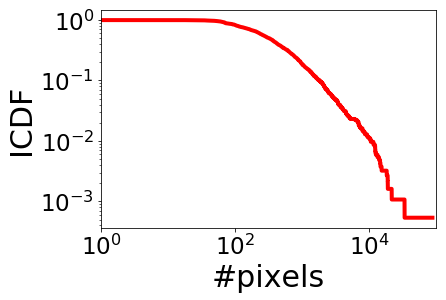

In [17]:
%matplotlib inline
def plot_pixels_per_project_icdf(count, output_file_name):
    plt.clf()

    ax = plt.subplot(111)
    ax.loglog(np.arange(count.shape[0]), count, color="red", linewidth=4)
    ax.set_ylabel('ICDF', fontsize=30)
    ax.set_xlabel('#pixels', fontsize=30)
    ax.tick_params(labelsize=23)
    ax.set_xlim(1,100000)
    plt.savefig(output_file_name, dpi=300, bbox_inches='tight')

#Computing ICDF
count = icdf(pixels_per_proj)
    
plot_pixels_per_project_icdf(count, "../plots/plot_pixels_icdf.svg")

<a id='Projects_per_User'></a>
# Projects per User

In [18]:
#Projects per User
#Only updates that aggree with the final color of the tile are considered
proj_per_user = projects_per_user(input_file_proj, projects_to_remove)

In [19]:
sorted_proj_per_user = sorted(proj_per_user.items(), key=operator.itemgetter(1), reverse=True)

#Top-10
for i in range(10):
    user = sorted_proj_per_user[i][0]
    n = sorted_proj_per_user[i][1]
    
    print("#", i, ", user: ", user, ", projects: ", n)

# 0 , user:  gIIoT+oPbML64+byH2Ms6FIj1sM= , projects:  126
# 1 , user:  Ij3o7pMe0KXqHHkMpLYeZY3lJpU= , projects:  96
# 2 , user:  oV/QBQVpRBPm5K4UoK73KXfcG0o= , projects:  94
# 3 , user:  ZSPEY69+JkkBBY/a3gb/jUvXIgA= , projects:  83
# 4 , user:  NPRAwHkxG3WBneXIpPgRvWXEBJE= , projects:  78
# 5 , user:  8xow27kDaned3b13ENiuQT9fmRE= , projects:  78
# 6 , user:  OsnDa+2E+woJy7TN3U87yLQrbu8= , projects:  73
# 7 , user:  wxcRqPge/H2RnT5msZNmnCGxQUM= , projects:  70
# 8 , user:  lnmjEGEWgq+s9joisWlkVYoEaUA= , projects:  69
# 9 , user:  RfWg9AaIkgiQAB+CsEEdaWqqp0g= , projects:  67


In [20]:
#Bottom-10

for i in range(1,11):
    user = sorted_proj_per_user[-i][0]
    n = sorted_proj_per_user[-i][1]
    
    print("#", i, ", user: ", user, ", projects: ", n)

# 1 , user:  O3rlOmb0o2qZie8tKKHl9smeUPw= , projects:  1
# 2 , user:  lgaE/V/9zREHrLMuFIswAvPxmew= , projects:  1
# 3 , user:  0c9D13zQkmgdniU8XVu4pXKcJIs= , projects:  1
# 4 , user:  fr+MDTWZFDofL7m2dBrNo70425Y= , projects:  1
# 5 , user:  zb4RPTmWb/00azu/FDHIEk9uJd4= , projects:  1
# 6 , user:  c/xCGHwfKIw5TZaKYv7kxl32H2A= , projects:  1
# 7 , user:  C02kpVSohDxkvU6+zEOk8XkLi+0= , projects:  1
# 8 , user:  RdnLjaedTkAdtiGNFiN90KvMFDo= , projects:  1
# 9 , user:  FFM2JLPM+c7EpK+xSwcMCyefTpo= , projects:  1
# 10 , user:  Ln9kGeSN2q2HB80ktOZHM1eahmw= , projects:  1


In [21]:
#AVG

print("AVG = ", np.mean(np.array(list(proj_per_user.values()))))

AVG =  4.67042303249509


In [23]:
#STD

print("STD = ", np.std(np.array(list(proj_per_user.values()))))

STD =  4.6313701272653605


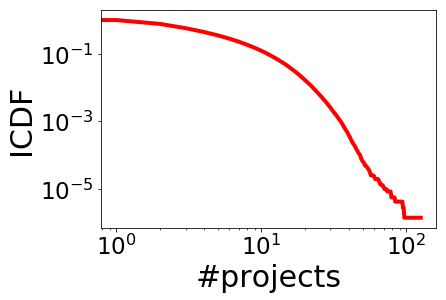

In [26]:
%matplotlib inline
def plot_projects_per_user_icdf(count, output_file_name):
    plt.clf()

    ax = plt.subplot(111)
    ax.loglog(np.arange(count.shape[0]), count, color="red", linewidth=4)
    ax.set_ylabel('ICDF', fontsize=30)
    ax.set_xlabel('#projects', fontsize=30)
    ax.tick_params(labelsize=23)
    #ax.set_yticks(np.arange(0,1.1,0.25))
    plt.savefig(output_file_name, dpi=300, bbox_inches='tight')
    
#Computing ICDF
count = icdf(proj_per_user)

plot_projects_per_user_icdf(count, "../plots/plot_proj_user_icdf.svg")

<a id='Users_per_Project'></a>

# Users per Project

In [53]:
# Users per Project
#Only updates that aggree with the final color of the tile are considered
users_per_proj = users_per_project(input_file_proj, projects_to_remove)   

In [54]:
sorted_users_per_proj = sorted(users_per_proj.items(), key=operator.itemgetter(1), reverse=True)

#Top-10
for i in range(10):
    proj = sorted_users_per_proj[i][0]
    n = sorted_users_per_proj[i][1]
    name = names[int(proj)]
    desc = descriptions[int(proj)]
    
    print("#", i, ", project: ", name, ", users: ", n, ", \ndesc: ", desc, "\n")

# 0 , project:  Rainbow Road , users:  129675 , 
desc:  One of the first projects on r/place, and also one of the largest. It integrates itself with many other artworks. 

# 1 , project:  USA / Canvas Center , users:  80931 , 
desc:  The center of the canvas was a controversial and disputed part of r/place. It began to be filled with numerous randomly placed pixels. As organized groups began creating masterpieces, the center began a white void, part of r/erase. As the original (dark) Void began to eat the center of the canvas, the USA Flag began to take shape covering a branch from the void. The flag took over the white void and a few projects including a smiley and a tree. Then the void reappeared in place and with other people erased most of the flag as RainbowRoad expanded where the flag was. Ireland saw an opportunity  and decided to expand as well. A net of yellow lines appeared and took over the void and r/AmericanFlaginPlace with help of r/TheDonald and other redditors, helped f

In [55]:
#Bottom-10

for i in range(1,11):
    proj = sorted_users_per_proj[-i][0]
    n = sorted_users_per_proj[-i][1]
    name = names[int(proj)]
    desc = descriptions[int(proj)]
    
    print("#", i, ", project: ", name, ", users: ", n, ", \ndesc: ", desc, "\n")

# 1 , project:  Smiley Face , users:  6 , 
desc:  A universal symbol of happiness rendered on a small scale for bite sized fun. 

# 2 , project:  The R , users:  7 , 
desc:  The R of the sub r/The_R 

# 3 , project:  BIGBANG , users:  9 , 
desc:  BIGBANG is a South Korean boy group who debuted in 2006 under YG Entertainment. The group, consisting of members T.O.P, Taeyang, Daesung, Seungri and leader G-Dragon are often labelled the 'Kings of K-pop' and can be considered the most influential boy group within Asia. Pictured to the left is the Bigbang crown which sits atop of the lightsticks which their fans (VIPs) wave and Bigbang concerts. 

# 4 , project:  CUL , users:  9 , 
desc:  CUL means "ass" in french.
We are very proud to have written this word a few hours before the end of /r/place.
This masterpiece is the work of Marvolo and Nicho. This is our gift to the internet. 

# 5 , project:  Bread , users:  9 , 
desc:  It's bread. 

# 6 , project:  Bread , users:  10 , 
desc:  A loaf o

In [56]:
#AVG

print("AVG = ", np.mean(np.array(list(users_per_proj.values()))))

AVG =  1810.680690399137


In [57]:
#STD

print("STD = ", np.std(np.array(list(users_per_proj.values()))))

STD =  5581.761266821517


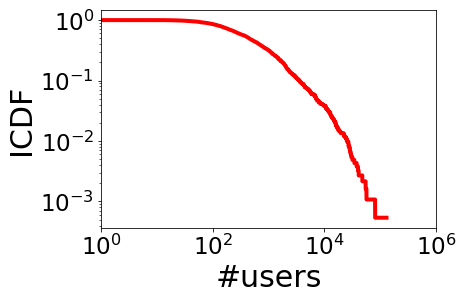

In [64]:
%matplotlib inline
def plot_users_per_project_icdf(count, output_file_name):
    plt.clf()

    ax = plt.subplot(111)
    ax.loglog(np.arange(count.shape[0]), count, color="red", linewidth=4)
    ax.set_ylabel('ICDF', fontsize=30)
    ax.set_xlabel('#users', fontsize=30)
    ax.tick_params(labelsize=23)
    ax.set_xlim(1, 1000000)
    plt.savefig(output_file_name, dpi=300, bbox_inches='tight')
    
#Computing ICDF
count = icdf(users_per_proj)

plot_users_per_project_icdf(count, "../plots/plot_user_proj_icdf.svg")

<a id='Time_per_Project'></a>
# Time per Project

In [65]:
#Time per project
#Only updates that aggree with the final color of the tile are considered
times_per_proj = times_per_project(input_file_proj, projects_to_remove)

In [76]:
sorted_times_per_proj = sorted(times_per_proj.items(), key=operator.itemgetter(1), reverse=True)

#Top-10
for i in range(10):
    proj = sorted_times_per_proj[i][0]
    t = sorted_times_per_proj[i][1] / (1000 * 60 * 60)
    name = names[int(proj)]
    desc = descriptions[int(proj)]
    
    print("#", i, ", project: ", name, ", time: ", t, ", \ndesc: ", desc, "\n")

# 0 , project:  USA / Canvas Center , time:  88.87472222222222 , 
desc:  The center of the canvas was a controversial and disputed part of r/place. It began to be filled with numerous randomly placed pixels. As organized groups began creating masterpieces, the center began a white void, part of r/erase. As the original (dark) Void began to eat the center of the canvas, the USA Flag began to take shape covering a branch from the void. The flag took over the white void and a few projects including a smiley and a tree. Then the void reappeared in place and with other people erased most of the flag as RainbowRoad expanded where the flag was. Ireland saw an opportunity  and decided to expand as well. A net of yellow lines appeared and took over the void and r/AmericanFlaginPlace with help of r/TheDonald and other redditors, helped fight for their territory and reconstruct the USA Flag. "E Pluribus Unum" on the side 

# 1 , project:  The First Void , time:  87.44777777777777 , 
desc:  The pl

In [67]:
#Bottom-10

for i in range(1,11):
    proj = sorted_times_per_proj[-i][0]
    t = sorted_times_per_proj[-i][1] / (1000 * 60 * 60)
    name = names[int(proj)]
    desc = descriptions[int(proj)]
    
    print("#", i, ", project: ", name, ", time: ", t, ", \ndesc: ", desc, "\n")

# 1 , project:  Seventeen , time:  10.676111111111112 , 
desc:  SEVENTEEN, or SVT, is a South Korean boy idol group that debuted in 2015 with Pledis Entertainment. Their members are divided into three sub-units. Their official fan club is known as Carat, with a jewel icon.  It is represented here in their fandom colors. 

# 2 , project:  Make Trade Fair , time:  16.12527777777778 , 
desc:  An organization supported by frontman Chris Martin of Coldplay drawn by the nearby Coldplay redditors. 

# 3 , project:  TOPS , time:  21.069166666666668 , 
desc:  A school program called TOPS, written in by 3-4 people, led by /u/Thunderbird2678. 

# 4 , project:  Lesbian Heart , time:  39.355555555555554 , 
desc:  A heart created by /r/TransFlagPlace to represent lesbians, women who are attracted to women. 

# 5 , project:  Tetris , time:  39.6825 , 
desc:  Depicts all 7 tetris pieces 

# 6 , project:  Smiley Face , time:  41.765 , 
desc:  A universal symbol of happiness rendered on a small scale fo

In [68]:
#AVG (hours)

print("AVG = ", np.mean(np.array(list(times_per_proj.values())))/(1000 * 60 * 60))

AVG =  69.86087558432219


In [69]:
#STD (hours)

print("STD = ", np.std(np.array(list(times_per_proj.values())))/(1000 * 60 * 60))

STD =  3.844378593733623


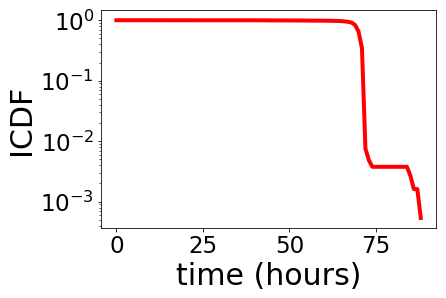

In [78]:
%matplotlib inline
def plot_times_per_project_icdf(count, output_file_name):
    plt.clf()

    ax = plt.subplot(111)
    ax.semilogy(np.arange(count.shape[0]), count, color="red", linewidth=4) #millisecons to hours
    ax.set_ylabel('ICDF', fontsize=30)
    ax.set_xlabel('time (hours)', fontsize=30)
    ax.tick_params(labelsize=23)
    #ax.set_xticks(np.arange(0,101,25))
    #ax.set_xlim(None, 100)
    #ax.set_yticks(np.arange(0,1.1,0.25))
    plt.savefig(output_file_name, dpi=300, bbox_inches='tight')
    
#Computing ICDF
times_per_proj_hours = {}

for proj in times_per_proj:
    times_per_proj_hours[proj] = int(times_per_proj[proj] / (1000 * 60 * 60))

count = icdf(times_per_proj_hours)

plot_times_per_project_icdf(count, "../plots/plot_time_proj_icdf.svg")

# !!From here and beyond, we need to re-organize!!

In [8]:
#Updates vs. entropy per project

X = np.zeros(len(updates_per_project))
Y = np.zeros(len(updates_per_project))
ratios = {}
IDs = []

i = 0
for p in updates_per_project.keys():
    up = updates_per_project[p]
    ent = entropy_per_project[p]
    
    X[i] = up
    Y[i] = ent
    
    ratios[p] = ent / up
    IDs.append(names[int(p)])
    
    i = i + 1
    
IDs = np.array(list(IDs), dtype=object)

In [9]:
#Showing project IDs on mouse hovering. Based on:
#https://stackoverflow.com/questions/7908636/possible-to-make-labels-appear-when-hovering-over-a-point-in-matplotlib

%matplotlib tk

cmap = plt.cm.RdYlGn
norm = plt.Normalize(1,4)

fig, ax = plt.subplots()
sc = ax.scatter(X, Y, color="green", marker='x', s=5)
ax.set_ylabel('entropy', fontsize=30)
ax.tick_params(labelsize=23)
ax.set_xlabel('#updates', fontsize=30)
ax.set_xscale('log')
ax.set_yticks(np.arange(np.min(Y),math.exp(1)+.1, .69))
    
annot = ax.annotate("", xy=(0,0), xytext=(5,5),textcoords="offset points", size=14)
annot.set_visible(False)   

def update_annot(ind):
    pos = sc.get_offsets()[ind["ind"][0]]
    annot.xy = pos
    text = "{}".format("".join(IDs[ind["ind"]]))
    annot.set_text(text)
    
def hover(event):
    vis = annot.get_visible()
    if event.inaxes == ax:
        cont, ind = sc.contains(event)
        if cont:
            update_annot(ind)
            annot.set_visible(True)
            fig.canvas.draw_idle()
        else:
            if vis:
                annot.set_visible(False)
                fig.canvas.draw_idle()
    
fig.canvas.mpl_connect("motion_notify_event", hover)

5

<Figure size 432x288 with 0 Axes>

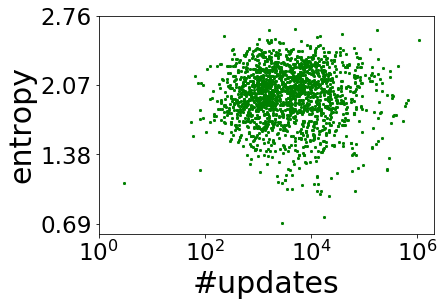

In [104]:
def plot_updates_vs_entropy(X, Y, output_file_name):
    plt.clf()

    fig, ax = plt.subplots()
    ax.scatter(X, Y, color="green", marker='x', s=5)
    ax.set_ylabel('entropy', fontsize=30)
    ax.tick_params(labelsize=23)
    ax.set_xlabel('#updates', fontsize=30)
    ax.set_xscale('log')
    ax.set_yticks(np.arange(0.69,math.exp(1)+.1, .69))
    ax.set_xlim(1,None)
    
    plt.savefig(output_file_name, dpi=300, bbox_inches='tight')

plot_updates_vs_entropy(X, Y, "../plots/plot_updates_vs_entropy.svg")

In [88]:
#Correlation

np.corrcoef(X, Y)

array([[ 1.        , -0.01240211],
       [-0.01240211,  1.        ]])

In [89]:
sorted_ratios = sorted(ratios.items(), key=operator.itemgetter(1), reverse=True)

In [94]:
#Entropy/update

for i in range(10):
    proj = sorted_ratios[i][0]
    name = names[int(proj)]
    desc = descriptions[int(proj)]
    r = sorted_ratios[i][1]
    ent = entropy_per_project[proj]
    up = updates_per_project[proj]
    
    print("#", i, ", project: ", name, ", entropy: ", ent, ", updates: ", up, ", entropy/update: ", r, "\
        , \ndescription: ", desc, "\n")

# 0 , project:  Climber's Head (TowerClimb) , entropy:  1.0986122886681096 , updates:  3 , entropy/update:  0.36620409622270317         , 
description:  These inconspicuous 4 pixels are actually the head of the protagonist from the roguelike platformer game "TowerClimb". 

# 1 , project:  Smiley Face , entropy:  2.1679025503594818 , updates:  66 , entropy/update:  0.03284700833878003         , 
description:  A universal symbol of happiness rendered on a small scale for bite sized fun. 

# 2 , project:  Eightfold , entropy:  1.7075036453641854 , updates:  55 , entropy/update:  0.03104552082480337         , 
description:  What remains of Eightfold, a paper spider character from a webcomic called Paranatural. 

# 3 , project:  Italy heart , entropy:  2.0908155810619586 , updates:  75 , entropy/update:  0.027877541080826115         , 
description:  A random heart or a symbol of cooperation between Scott Pilgrim and Italy? 

# 4 , project:  Tiny danish flag , entropy:  1.5603830291635967 , 

In [100]:
for i in range(1,11):
    proj = sorted_ratios[-i][0]
    name = names[int(proj)]
    desc = descriptions[int(proj)]
    r = sorted_ratios[-i][1]
    ent = entropy_per_project[proj]
    up = updates_per_project[proj]
    
    print("#", i, "project: ", p, "entropy: ", ent, " updates: ", up, " entropy/update: ", r,"\
        ndescription: ", desc, "\n")    

# 1 project:  1066 entropy:  2.5201075806834554  updates:  1078220  entropy/update:  2.337285137247923e-06         ndescription:  One of the first projects on r/place, and also one of the largest. It integrates itself with many other artworks. 

# 2 project:  1066 entropy:  1.9258022777284207  updates:  684179  entropy/update:  2.814763793873271e-06         ndescription:  The center of the canvas was a controversial and disputed part of r/place. It began to be filled with numerous randomly placed pixels. As organized groups began creating masterpieces, the center began a white void, part of r/erase. As the original (dark) Void began to eat the center of the canvas, the USA Flag began to take shape covering a branch from the void. The flag took over the white void and a few projects including a smiley and a tree. Then the void reappeared in place and with other people erased most of the flag as RainbowRoad expanded where the flag was. Ireland saw an opportunity  and decided to expand as

In [360]:
#Updates vs. pixels per project

X = np.zeros(len(updates_per_project))
Y = np.zeros(len(updates_per_project))
ratios = {}
IDs = []

i = 0
for p in updates_per_project.keys():
    up = updates_per_project[p]
    pix = pixels_per_project[p]
    
    X[i] = up
    Y[i] = pix
    
    ratios[p] = pix / up
    IDs.append(names[int(p)])
    
    i = i + 1
    
IDs = np.array(list(IDs), dtype=object)

In [361]:
%matplotlib tk

cmap = plt.cm.RdYlGn
norm = plt.Normalize(1,4)

fig, ax = plt.subplots()
sc = ax.scatter(X, Y, color="green", marker='x', s=5)
ax.scatter(X, Y, color="green", marker='x', s=5)
ax.set_ylabel('#pixels', fontsize=30)
ax.tick_params(labelsize=23)
ax.set_xlabel('#updates', fontsize=30)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1,1000000)
ax.set_xlim(1,None)
    
annot = ax.annotate("", xy=(0,0), xytext=(5,5),textcoords="offset points", size=14)
annot.set_visible(False)   

def update_annot(ind):
    pos = sc.get_offsets()[ind["ind"][0]]
    annot.xy = pos
    text = "{}".format("".join(IDs[ind["ind"]]))
    annot.set_text(text)
    
def hover(event):
    vis = annot.get_visible()
    if event.inaxes == ax:
        cont, ind = sc.contains(event)
        if cont:
            update_annot(ind)
            annot.set_visible(True)
            fig.canvas.draw_idle()
        else:
            if vis:
                annot.set_visible(False)
                fig.canvas.draw_idle()
    
fig.canvas.mpl_connect("motion_notify_event", hover)

5

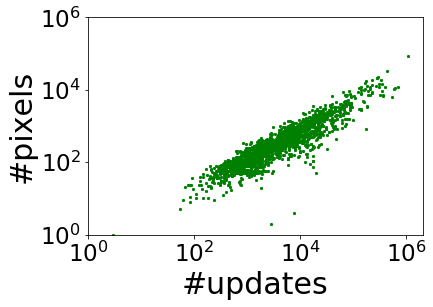

In [169]:
def plot_updates_vs_pixels(X, Y, output_file_name):
    plt.clf()

    ax = plt.subplot(111)
    ax.scatter(X, Y, color="green", marker='x', s=5)
    ax.set_ylabel('#pixels', fontsize=30)
    ax.tick_params(labelsize=23)
    ax.set_xlabel('#updates', fontsize=30)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylim(1,1000000)
    ax.set_xlim(1,None)
    plt.savefig(output_file_name, dpi=300, bbox_inches='tight')

plot_updates_vs_pixels(X, Y, "../plots/plot_updates_vs_pixels.svg")

In [103]:
#Correlation

np.corrcoef(X, Y)

array([[1.        , 0.84277543],
       [0.84277543, 1.        ]])

In [104]:
sorted_ratios = sorted(ratios.items(), key=operator.itemgetter(1), reverse=True)

In [106]:
#Pixels/update
    
for i in range(10):
    proj = sorted_ratios[i][0]
    name = names[int(proj)]
    desc = descriptions[int(proj)]
    r = sorted_ratios[i][1]
    pix = pixels_per_project[proj]
    up = updates_per_project[proj]
    
    print("#", i, ", project: ", name, ", pixels: ", pix, ", updates: ", up, ", pixels/update: ", r, "\
        , \ndescription: ", desc, "\n")

# 0 , project:  Seplunky , pixels:  336 , updates:  821 , pixels/update:  0.4092570036540804         , 
description:  Player character from the platform indie game Spelunky. 

# 1 , project:  Bread , pixels:  65 , updates:  167 , pixels/update:  0.38922155688622756         , 
description:  A loaf of Bread constructed by a few users of Anarchist subreddits to represent the ideas of Pyotr Kropotkin, Russian anarchist and author of the influential anarchist book, 'The Conquest of Bread'. Since this was a relatively late addition to the place, and is not a particularly obviously Leftist symbol, the Bread saw little vandalism and required no bots to maintain. 

# 2 , project:  Amaura , pixels:  36 , updates:  93 , pixels/update:  0.3870967741935484         , 
description:  The head of the Generation 6 Fossil Pokémon Amaura. The body was covered up by surrounding art. 

# 3 , project:  Bread , pixels:  77 , updates:  203 , pixels/update:  0.3793103448275862         , 
description:  It's brea

In [108]:
for i in range(1,11):
    proj = sorted_ratios[-i][0]
    name = names[int(proj)]
    desc = descriptions[int(proj)]
    r = sorted_ratios[-i][1]
    pix = pixels_per_project[proj]
    up = updates_per_project[proj]
    
    print("#", i, ", project: ", name, ", pixels: ", pix, ", updates: ", up, ", pixels/update: ", r, "\
        , \ndescription: ", desc, "\n")

# 1 , project:  The purple corner , pixels:  4 , updates:  7701 , pixels/update:  0.0005194130632385404         , 
description:  Originally a "colony" of the blue corner, a loss of interest among blue corner pixel-placers lead to the upper-left corner of the canvas being taken over by the faction that would eventually become /r/purplepixels. However, like all of the colour factions that dominated the early Place, the purple corner was eventually crowded out by pixel art. 

# 2 , project:  PINLAND , pixels:  2 , updates:  2872 , pixels/update:  0.0006963788300835655         , 
description:  It was very common for users to change these few pixels so the F turned into a P 

# 3 , project:  Trans Heart , pixels:  51 , updates:  19655 , pixels/update:  0.0025947596031544134         , 
description:  The first heart created by /r/TransFlagPlace, marking the centerpoint of the flag. 

# 4 , project:  (covered) 7-1 , pixels:  72 , updates:  17723 , pixels/update:  0.004062517632455002         ,

In [14]:
#Updates vs. users per project

X = np.zeros(len(updates_per_project))
Y = np.zeros(len(updates_per_project))
ratios = {}
IDs = []

i = 0
for p in updates_per_project.keys():
    up = updates_per_project[p]
    usr = users_per_project[p]
    
    X[i] = up
    Y[i] = usr
    
    ratios[p] = usr / up
    IDs.append(names[int(p)])
    
    i = i + 1
    
IDs = np.array(list(IDs), dtype=object)

In [15]:
%matplotlib tk

cmap = plt.cm.RdYlGn
norm = plt.Normalize(1,4)

fig, ax = plt.subplots()
sc = ax.scatter(X, Y, color="green", marker='x', s=5)
ax.scatter(X, Y, color="green", marker='x', s=5)
ax.set_ylabel('#users', fontsize=30)
ax.tick_params(labelsize=23)
ax.set_xlabel('#updates', fontsize=30)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1,1000000)
ax.set_xlim(1,None)
    
annot = ax.annotate("", xy=(0,0), xytext=(5,5),textcoords="offset points", size=14)
annot.set_visible(False)   

def update_annot(ind):
    pos = sc.get_offsets()[ind["ind"][0]]
    annot.xy = pos
    text = "{}".format("".join(IDs[ind["ind"]]))
    annot.set_text(text)
    
def hover(event):
    vis = annot.get_visible()
    if event.inaxes == ax:
        cont, ind = sc.contains(event)
        if cont:
            update_annot(ind)
            annot.set_visible(True)
            fig.canvas.draw_idle()
        else:
            if vis:
                annot.set_visible(False)
                fig.canvas.draw_idle()
    
fig.canvas.mpl_connect("motion_notify_event", hover)

5

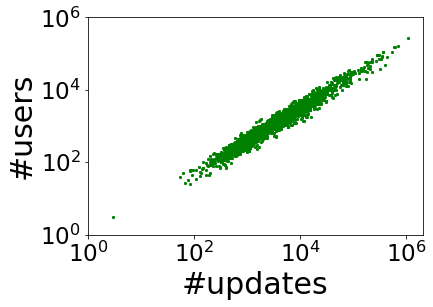

In [171]:
def plot_updates_vs_users(X, Y, output_file_name):
    plt.clf()

    ax = plt.subplot(111)
    ax.scatter(X, Y, color="green", marker='x', s=5)
    ax.set_ylabel('#users', fontsize=30)
    ax.tick_params(labelsize=23)
    ax.set_xlabel('#updates', fontsize=30)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylim(1,1000000)
    ax.set_xlim(1,None)
    
    plt.savefig(output_file_name, dpi=300, bbox_inches='tight')

plot_updates_vs_users(X, Y, "../plots/plot_updates_vs_users.svg")

In [126]:
#Correlation

np.corrcoef(X, Y)

array([[1.        , 0.13952994],
       [0.13952994, 1.        ]])

In [127]:
sorted_ratios = sorted(ratios.items(), key=operator.itemgetter(1), reverse=True)

In [116]:
#Users/update

for i in range(10):
    proj = sorted_ratios[i][0]
    name = names[int(proj)]
    desc = descriptions[int(proj)]
    r = sorted_ratios[i][1]
    usr = users_per_project[proj]
    up = updates_per_project[proj]
    
    print("#", i, ", project: ", name, ", users: ", usr, ", updates: ", up, ", users/update: ", r, "\
        , \ndescription: ", desc, "\n")

# 0 , project:  Climber's Head (TowerClimb) , users:  3 , updates:  3 , users/update:  1.0         , 
description:  These inconspicuous 4 pixels are actually the head of the protagonist from the roguelike platformer game "TowerClimb". 

# 1 , project:  Remnants of a Pokeball , users:  1295 , updates:  1486 , users/update:  0.8714670255720054         , 
description:  Remnants of a small pokeball. 

# 2 , project:  Pokeball , users:  1404 , updates:  1669 , users/update:  0.8412222887956861         , 
description:   

# 3 , project:  Pokéball , users:  1477 , updates:  1768 , users/update:  0.8354072398190046         , 
description:  A device used to capture Pokémon. 

# 4 , project:  Google Android Head , users:  645 , updates:  780 , users/update:  0.8269230769230769         , 
description:  Head of the Google Android created by /u/Jestified 

# 5 , project:  Pokeball , users:  1533 , updates:  1854 , users/update:  0.8268608414239482         , 
description:  An item from the Pokemon f

In [117]:
for i in range(1,11):
    proj = sorted_ratios[-i][0]
    name = names[int(proj)]
    desc = descriptions[int(proj)]
    r = sorted_ratios[-i][1]
    usr = users_per_project[proj]
    up = updates_per_project[proj]
    
    print("#", i, ", project: ", name, ", users: ", usr, ", updates: ", up, ", users/update: ", r, "\
        , \ndescription: ", desc, "\n")

# 1 , project:  University Of Texas at Austin , users:  1759 , updates:  15686 , users/update:  0.11213821241871733         , 
description:  University located in Austin, Texas USA. Their school colors are white and burnt orange.   

# 2 , project:  The Far Left Side , users:  36757 , updates:  324259 , users/update:  0.11335691530535776         , 
description:  The Far left side was made up of dedicated Leftists working together to create a community on r/place 

# 3 , project:  The Far Left Side , users:  47034 , updates:  402175 , users/update:  0.1169490893267856         , 
description:  The section of the canvas mostly filled with Leftist symbols, but also including pixel art and flags. <br>This area was under near-constant siege, especially the Hammer and Sickle. 

# 4 , project:  Hammer and Sickle , users:  20180 , updates:  171275 , users/update:  0.11782221573492921         , 
description:  Symbol of workers tools used to represent communism. 

# 5 , project:  Three bikes in t

In [16]:
#Updates vs. time

X = np.zeros(len(updates_per_project))
Y = np.zeros(len(updates_per_project))
ratios = {}
IDs = []

i = 0
for p in updates_per_project.keys():
    up = updates_per_project[p]
    t = times_per_project[p] / (1000 * 60 * 60)
    
    X[i] = up
    Y[i] = t
    
    ratios[p] = t / up
    
    IDs.append(names[int(p)])
    
    i = i + 1
    
IDs = np.array(list(IDs), dtype=object)

In [18]:
%matplotlib tk

cmap = plt.cm.RdYlGn
norm = plt.Normalize(1,4)

fig, ax = plt.subplots()
sc = ax.scatter(X, Y, color="green", marker='x', s=5)
ax.scatter(X, Y, color="green", marker='x', s=5)
ax.scatter(X, Y, color="green", marker='x', s=5)
ax.set_ylabel('time (hours)', fontsize=30)
ax.tick_params(labelsize=23)
ax.set_xlabel('#updates', fontsize=30)
ax.set_xscale('log')
ax.set_xlim(1,None)
ax.set_ylim(0,100)
    
annot = ax.annotate("", xy=(0,0), xytext=(5,5),textcoords="offset points", size=14)
annot.set_visible(False)   

def update_annot(ind):
    pos = sc.get_offsets()[ind["ind"][0]]
    annot.xy = pos
    text = "{}".format("".join(IDs[ind["ind"]]))
    annot.set_text(text)
    
def hover(event):
    vis = annot.get_visible()
    if event.inaxes == ax:
        cont, ind = sc.contains(event)
        if cont:
            update_annot(ind)
            annot.set_visible(True)
            fig.canvas.draw_idle()
        else:
            if vis:
                annot.set_visible(False)
                fig.canvas.draw_idle()
    
fig.canvas.mpl_connect("motion_notify_event", hover)

5

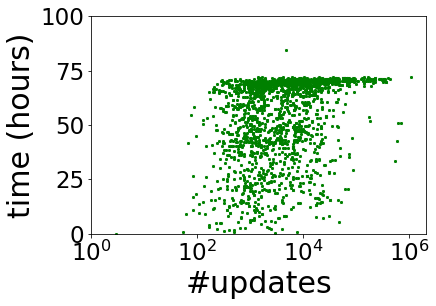

In [176]:
def plot_updates_vs_times(X, Y, output_file_name):
    plt.clf()

    ax = plt.subplot(111)
    ax.scatter(X, Y, color="green", marker='x', s=5)
    ax.set_ylabel('time (hours)', fontsize=30)
    ax.tick_params(labelsize=23)
    ax.set_xlabel('#updates', fontsize=30)
    ax.set_xscale('log')
    ax.set_xlim(1,None)
    ax.set_ylim(0,100)
    plt.savefig(output_file_name, dpi=300, bbox_inches='tight')

plot_updates_vs_times(X, Y, "../plots/plot_updates_vs_times.svg")

In [130]:
#Correlation

np.corrcoef(X, Y)

array([[1.        , 0.13952994],
       [0.13952994, 1.        ]])

In [185]:
sorted_ratios = sorted(ratios.items(), key=operator.itemgetter(1), reverse=True)

In [186]:
#Time/update

for i in range(10):
    proj = sorted_ratios[i][0]
    name = names[int(proj)]
    desc = descriptions[int(proj)]
    r = sorted_ratios[i][1]
    tm = times_per_project[proj] / (1000 * 60 * 60)
    up = updates_per_project[proj]
    
    print("#", i, ", project: ", name, ", time: ", tm, ", updates: ", up, ", times/update: ", r, "\
        , \ndescription: ", desc, "\n")    

# 0 , project:  Italy heart , time:  54.689166666666665 , updates:  75 , times/update:  0.7291888888888889         , 
description:  A random heart or a symbol of cooperation between Scott Pilgrim and Italy? 

# 1 , project:  Red P , time:  58.28722222222222 , updates:  86 , times/update:  0.6777583979328164         , 
description:  Seeing the whole work was an amazing piece of modern art, I really wanted to be a part of it. I decided to find a small unused spot and put my initial there. The void and erase factions were savage and had wiped two previous efforts and a larger piece of art I was helping maintain, so I found a spot and used a script running on 2 PC's to maintain my small part of the artwork until place ended, which happened while I was sleeping. 

# 2 , project:  Smiley Face , time:  41.72138888888889 , updates:  66 , times/update:  0.6321422558922559         , 
description:  A universal symbol of happiness rendered on a small scale for bite sized fun. 

# 3 , project:  Ama

In [187]:
for i in range(1,11):
    proj = sorted_ratios[-i][0]
    name = names[int(proj)]
    desc = descriptions[int(proj)]
    r = sorted_ratios[-i][1]
    tm = times_per_project[proj] / (1000 * 60 * 60)
    up = updates_per_project[proj]
    
    print("#", i, ", project: ", name, ", time: ", tm, ", updates: ", up, ", times/update: ", r, "\
        , \ndescription: ", desc, "\n")    

# 1 , project:  Climber's Head (TowerClimb) , time:  0.0 , updates:  3 , times/update:  0.0         , 
description:  These inconspicuous 4 pixels are actually the head of the protagonist from the roguelike platformer game "TowerClimb". 

# 2 , project:  osu! Logo , time:  33.25222222222222 , updates:  540508 , times/update:  6.152031463405208e-05         , 
description:  The logo for the rhythm game osu. This was one of the more ambitious projects of /r/place and was intended to be more detailed. Unfortunately, a LoL player by the name of loltyler1, told his fans to attack the logo by filling it with the void, resulting in its current vandalized state. 

# 3 , project:  The purple corner , time:  0.5097222222222222 , updates:  7701 , times/update:  6.618909521130012e-05         , 
description:  Originally a "colony" of the blue corner, a loss of interest among blue corner pixel-placers lead to the upper-left corner of the canvas being taken over by the faction that would eventually bec

In [387]:
#Pixels vs. entropy per project

X = np.zeros(len(updates_per_project))
Y = np.zeros(len(updates_per_project))
ratios = {}
IDs = []

i = 0
for p in updates_per_project.keys():
    ent = entropy_per_project[p]
    pix = pixels_per_project[p]
    
    Y[i] = ent
    X[i] = pix
    
    ratios[p] = ent / pix
    IDs.append(names[int(p)])
    
    i = i + 1
    
IDs = np.array(list(IDs), dtype=object)

In [388]:
%matplotlib tk

cmap = plt.cm.RdYlGn
norm = plt.Normalize(1,4)

fig, ax = plt.subplots()
sc = ax.scatter(X, Y, color="green", marker='x', s=5)
ax.scatter(X, Y, color="green", marker='x', s=5)
ax.set_ylabel('entropy', fontsize=30)
ax.tick_params(labelsize=23)
ax.set_xlabel('#pixels', fontsize=30)
ax.set_yticks(np.arange(0.69,math.exp(1)+.1, .69))
ax.set_xscale('log')
ax.set_xlim(1,1000000)
    
annot = ax.annotate("", xy=(0,0), xytext=(5,5),textcoords="offset points", size=14)
annot.set_visible(False)   

def update_annot(ind):
    pos = sc.get_offsets()[ind["ind"][0]]
    annot.xy = pos
    text = "{}".format("".join(IDs[ind["ind"]]))
    annot.set_text(text)
    
def hover(event):
    vis = annot.get_visible()
    if event.inaxes == ax:
        cont, ind = sc.contains(event)
        if cont:
            update_annot(ind)
            annot.set_visible(True)
            fig.canvas.draw_idle()
        else:
            if vis:
                annot.set_visible(False)
                fig.canvas.draw_idle()
    
fig.canvas.mpl_connect("motion_notify_event", hover)

5

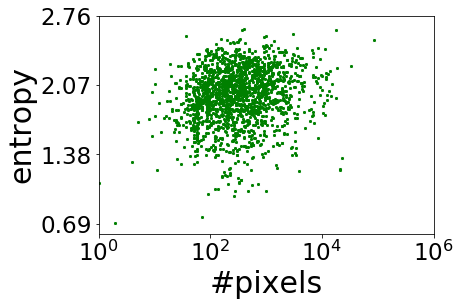

In [189]:
def plot_pixels_vs_entropy(X, Y, output_file_name):
    plt.clf()

    ax = plt.subplot(111)
    ax.scatter(X, Y, color="green", marker='x', s=5)
    ax.set_ylabel('entropy', fontsize=30)
    ax.tick_params(labelsize=23)
    ax.set_xlabel('#pixels', fontsize=30)
    ax.set_yticks(np.arange(0.69,math.exp(1)+.1, .69))
    ax.set_xscale('log')
    ax.set_xlim(1,1000000)
    plt.savefig(output_file_name, dpi=300, bbox_inches='tight')

plot_pixels_vs_entropy(X, Y, "../plots/plot_pixels_vs_entropy.svg")

In [139]:
#Correlation

np.corrcoef(X, Y)

array([[1.        , 0.07472808],
       [0.07472808, 1.        ]])

In [140]:
sorted_ratios = sorted(ratios.items(), key=operator.itemgetter(1), reverse=True)

In [141]:
#Entropy/pixel
   
for i in range(10):
    proj = sorted_ratios[i][0]
    name = names[int(proj)]
    desc = descriptions[int(proj)]
    r = sorted_ratios[i][1]
    ent = entropy_per_project[proj]
    pix = pixels_per_project[proj]
    
    print("#", i, ", project: ", name, ", entropy: ", ent, ", pixels: ", pix, ", entropy/pixel: ", r, "\
        , \ndescription: ", desc, "\n")    

# 0 , project:  Climber's Head (TowerClimb) , entropy:  1.0986122886681096 , pixels:  1 , entropy/pixel:  1.0986122886681096         , 
description:  These inconspicuous 4 pixels are actually the head of the protagonist from the roguelike platformer game "TowerClimb". 

# 1 , project:  PINLAND , entropy:  0.6928361704898555 , pixels:  2 , entropy/pixel:  0.34641808524492773         , 
description:  It was very common for users to change these few pixels so the F turned into a P 

# 2 , project:  Eightfold , entropy:  1.7075036453641854 , pixels:  5 , entropy/pixel:  0.3415007290728371         , 
description:  What remains of Eightfold, a paper spider character from a webcomic called Paranatural. 

# 3 , project:  The purple corner , entropy:  1.302178642906814 , pixels:  4 , entropy/pixel:  0.3255446607267035         , 
description:  Originally a "colony" of the blue corner, a loss of interest among blue corner pixel-placers lead to the upper-left corner of the canvas being taken over 

In [142]:
for i in range(1,11):
    proj = sorted_ratios[-i][0]
    name = names[int(proj)]
    desc = descriptions[int(proj)]
    r = sorted_ratios[-i][1]
    ent = entropy_per_project[proj]
    pix = pixels_per_project[proj]
    
    print("#", i, ", project: ", name, ", entropy: ", ent, ", pixels: ", pix, ", entropy/pixel: ", r, "\
        , \ndescription: ", desc, "\n")    

# 1 , project:  Rainbow Road , entropy:  2.5201075806834554 , pixels:  87255 , entropy/pixel:  2.888209937176615e-05         , 
description:  One of the first projects on r/place, and also one of the largest. It integrates itself with many other artworks. 

# 2 , project:  Darth Plagueis The Wise , entropy:  1.2235034441598396 , pixels:  21406 , entropy/pixel:  5.7157032802010635e-05         , 
description:  One of the first additions to the map, this text of a meme from the prequel Star Wars movies started out as an uncoordinated attempt to write something everyone knew, and was refined to the masterpiece you see today. 

# 3 , project:  Did you ever hear the Tragedy of Darth Plagueis the Wise? , entropy:  1.238122435906646 , pixels:  21401 , entropy/pixel:  5.7853485159882534e-05         , 
description:  It's a Sith legend. Darth Plagueis was a Dark Lord of the Sith so powerful and so wise, he could use the Force to influence the midi-chlorians to create...life. He had such a knowled

In [368]:
#Pixels vs. users per project

X = np.zeros(len(updates_per_project))
Y = np.zeros(len(updates_per_project))
ratios = {}
IDs = []

i = 0
for p in updates_per_project.keys():
    usr = users_per_project[p]
    pix = pixels_per_project[p]
    
    Y[i] = usr
    X[i] = pix
    
    ratios[p] = usr / pix
    
    IDs.append(names[int(p)])
    
    i = i + 1
    
IDs = np.array(list(IDs), dtype=object)

In [369]:
%matplotlib tk

cmap = plt.cm.RdYlGn
norm = plt.Normalize(1,4)

fig, ax = plt.subplots()
sc = ax.scatter(X, Y, color="green", marker='x', s=5)
ax.scatter(X, Y, color="green", marker='x', s=5)
ax.set_ylabel('#users', fontsize=30)
ax.tick_params(labelsize=23)
ax.set_xlabel('#pixels', fontsize=30)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1,1000000)
ax.set_xlim(1,1000000)
    
annot = ax.annotate("", xy=(0,0), xytext=(5,5),textcoords="offset points", size=14)
annot.set_visible(False)   

def update_annot(ind):
    pos = sc.get_offsets()[ind["ind"][0]]
    annot.xy = pos
    text = "{}".format("".join(IDs[ind["ind"]]))
    annot.set_text(text)
    
def hover(event):
    vis = annot.get_visible()
    if event.inaxes == ax:
        cont, ind = sc.contains(event)
        if cont:
            update_annot(ind)
            annot.set_visible(True)
            fig.canvas.draw_idle()
        else:
            if vis:
                annot.set_visible(False)
                fig.canvas.draw_idle()
    
fig.canvas.mpl_connect("motion_notify_event", hover)

5

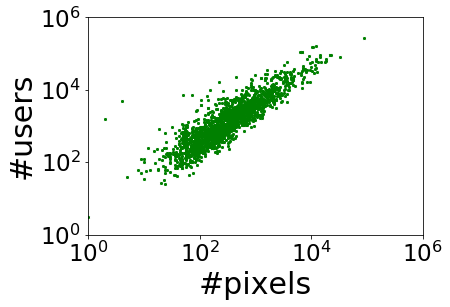

In [192]:
def plot_pixels_vs_users(X, Y, output_file_name):
    plt.clf()

    ax = plt.subplot(111)
    ax.scatter(X, Y, color="green", marker='x', s=5)
    ax.set_ylabel('#users', fontsize=30)
    ax.tick_params(labelsize=23)
    ax.set_xlabel('#pixels', fontsize=30)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylim(1,1000000)
    ax.set_xlim(1,1000000)
    plt.savefig(output_file_name, dpi=300, bbox_inches='tight')

plot_pixels_vs_users(X, Y, "../plots/plot_pixels_vs_users.svg")

In [145]:
#Correlation

np.corrcoef(X, Y)

array([[1.        , 0.84457543],
       [0.84457543, 1.        ]])

In [146]:
sorted_ratios = sorted(ratios.items(), key=operator.itemgetter(1), reverse=True)

In [147]:
#Users/pixel

for i in range(10):
    proj = sorted_ratios[i][0]
    name = names[int(proj)]
    desc = descriptions[int(proj)]
    r = sorted_ratios[i][1]
    usr = users_per_project[proj]
    pix = pixels_per_project[proj]
    
    print("#", i, ", project: ", name, ", users: ", usr, ", pixels: ", pix, ", users/pixel: ", r, "\
        , \ndescription: ", desc, "\n")    

# 0 , project:  The purple corner , users:  4849 , pixels:  4 , users/pixel:  1212.25         , 
description:  Originally a "colony" of the blue corner, a loss of interest among blue corner pixel-placers lead to the upper-left corner of the canvas being taken over by the faction that would eventually become /r/purplepixels. However, like all of the colour factions that dominated the early Place, the purple corner was eventually crowded out by pixel art. 

# 1 , project:  PINLAND , users:  1589 , pixels:  2 , users/pixel:  794.5         , 
description:  It was very common for users to change these few pixels so the F turned into a P 

# 2 , project:  Trans Heart , users:  7072 , pixels:  51 , users/pixel:  138.66666666666666         , 
description:  The first heart created by /r/TransFlagPlace, marking the centerpoint of the flag. 

# 3 , project:  (covered) 7-1 , users:  6895 , pixels:  72 , users/pixel:  95.76388888888889         , 
description:  The corner of the Brazil Flag that was

In [148]:
for i in range(1,11):
    proj = sorted_ratios[-i][0]
    name = names[int(proj)]
    desc = descriptions[int(proj)]
    r = sorted_ratios[-i][1]
    usr = users_per_project[proj]
    pix = pixels_per_project[proj]
    
    print("#", i, ", project: ", name, ", users: ", usr, ", pixels: ", pix, ", users/pixel: ", r, "\
        , \ndescription: ", desc, "\n")    

# 1 , project:  Bread , users:  43 , pixels:  65 , users/pixel:  0.6615384615384615         , 
description:  A loaf of Bread constructed by a few users of Anarchist subreddits to represent the ideas of Pyotr Kropotkin, Russian anarchist and author of the influential anarchist book, 'The Conquest of Bread'. Since this was a relatively late addition to the place, and is not a particularly obviously Leftist symbol, the Bread saw little vandalism and required no bots to maintain. 

# 2 , project:  Bread , users:  51 , pixels:  77 , users/pixel:  0.6623376623376623         , 
description:  It's bread. 

# 3 , project:  Seplunky , users:  236 , pixels:  336 , users/pixel:  0.7023809523809523         , 
description:  Player character from the platform indie game Spelunky. 

# 4 , project:  Toucan , users:  273 , pixels:  326 , users/pixel:  0.8374233128834356         , 
description:  le toucan has arrived sheepoToucan 

# 5 , project:  Foliat , users:  180 , pixels:  206 , users/pixel:  0.873

In [371]:
#Pixels vs. time per project

X = np.zeros(len(updates_per_project))
Y = np.zeros(len(updates_per_project))
ratios = {}
IDs = []

i = 0
for p in updates_per_project.keys():
    t = times_per_project[p] / (1000 * 60 * 60)
    pix = pixels_per_project[p]
    
    Y[i] = t 
    X[i] = pix
    
    ratios[p] = t / pix
    
    IDs.append(names[int(p)])
    
    i = i + 1
    
IDs = np.array(list(IDs), dtype=object)

In [372]:
%matplotlib tk

cmap = plt.cm.RdYlGn
norm = plt.Normalize(1,4)

fig, ax = plt.subplots()
sc = ax.scatter(X, Y, color="green", marker='x', s=5)
ax.scatter(X, Y, color="green", marker='x', s=5)
ax.set_ylabel('time (hours)', fontsize=30)
ax.tick_params(labelsize=23)
ax.set_xlabel('#pixels', fontsize=30)
ax.set_xscale('log')
ax.set_ylim(0,100)
ax.set_xlim(1,1000000)
    
annot = ax.annotate("", xy=(0,0), xytext=(5,5),textcoords="offset points", size=14)
annot.set_visible(False)   

def update_annot(ind):
    pos = sc.get_offsets()[ind["ind"][0]]
    annot.xy = pos
    text = "{}".format("".join(IDs[ind["ind"]]))
    annot.set_text(text)
    
def hover(event):
    vis = annot.get_visible()
    if event.inaxes == ax:
        cont, ind = sc.contains(event)
        if cont:
            update_annot(ind)
            annot.set_visible(True)
            fig.canvas.draw_idle()
        else:
            if vis:
                annot.set_visible(False)
                fig.canvas.draw_idle()
    
fig.canvas.mpl_connect("motion_notify_event", hover)

5

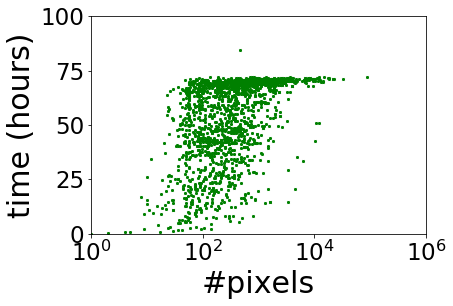

In [278]:
def plot_pixels_vs_times(X, Y, output_file_name):
    plt.clf()

    ax = plt.subplot(111)
    ax.scatter(X, Y, color="green", marker='x', s=5)
    ax.set_ylabel('time (hours)', fontsize=30)
    ax.tick_params(labelsize=23)
    ax.set_xlabel('#pixels', fontsize=30)
    ax.set_xscale('log')
    ax.set_ylim(0,100)
    ax.set_xlim(1,1000000)
    plt.savefig(output_file_name, dpi=300, bbox_inches='tight')

plot_pixels_vs_times(X, Y, "../plots/plot_pixels_vs_times.svg")

In [151]:
#Correlation

np.corrcoef(X, Y)

array([[1.        , 0.18451768],
       [0.18451768, 1.        ]])

In [152]:
sorted_ratios = sorted(ratios.items(), key=operator.itemgetter(1), reverse=True)

In [154]:
#Time/Pixel

for i in range(10):
    proj = sorted_ratios[i][0]
    name = names[int(proj)]
    desc = descriptions[int(proj)]
    r = sorted_ratios[i][1]
    tm = times_per_project[proj] / (1000 * 60 * 60)
    pix = pixels_per_project[proj]
    
    print("#", i, ", project: ", name, ", time: ", tm, ", pixels: ", pix, ", time/pixel: ", r, "\
        , \ndescription: ", desc, "\n")    

# 0 , project:  The Tree , time:  34.255 , pixels:  12 , time/pixel:  10276500.0         , 
description:  On a canvas dominated by fierce territorialism and grandiose schemes, The Tree cast aside these common ideologies to become something simple, something pure.
The Tree represents a common principle to its followers, the idea of not getting wholly caught up in the rush, the flow of the crowd, the ability to stand on one's own feet, the ability to look back and say to oneself, "I will not be blinded by faith."
The Tree represents this just by being what it is, a small part of a much, much larger crowd. In that regard, The Tree also represents us all. We are The Tree, and The Tree is all of us. So while the tree may have been destroyed, it is still alive in all of us. 

# 1 , project:  Danish Heart , time:  63.8975 , pixels:  23 , time/pixel:  10001347.826086957         , 
description:  The flag of Denmark, or Dannebrog, in the shape of a heart, was almost overtaken by the /r/sweden 



In [285]:
for i in range(1,11):
    proj = sorted_ratios[-i][0]
    name = names[int(proj)]
    desc = descriptions[int(proj)]
    r = sorted_ratios[-i][1]
    tm = times_per_project[proj] / (1000 * 60 * 60)
    pix = pixels_per_project[proj]
    
    print("#", i, ", project: ", name, ", time: ", tm, ", pixels: ", pix, ", time/pixel: ", r, "\
        , \ndescription: ", desc, "\n")    

# 1 , project:  Climber's Head (TowerClimb) , time:  0.0 , pixels:  1 , time/pixel:  0.0         , 
description:  These inconspicuous 4 pixels are actually the head of the protagonist from the roguelike platformer game "TowerClimb". 

# 2 , project:  osu! Logo , time:  33.25222222222222 , pixels:  6204 , time/pixel:  6.152031463405208e-05         , 
description:  The logo for the rhythm game osu. This was one of the more ambitious projects of /r/place and was intended to be more detailed. Unfortunately, a LoL player by the name of loltyler1, told his fans to attack the logo by filling it with the void, resulting in its current vandalized state. 

# 3 , project:  The purple corner , time:  0.5097222222222222 , pixels:  4 , time/pixel:  6.618909521130012e-05         , 
description:  Originally a "colony" of the blue corner, a loss of interest among blue corner pixel-placers lead to the upper-left corner of the canvas being taken over by the faction that would eventually become /r/purplep

In [373]:
#Users vs. entropy per project

X = np.zeros(len(updates_per_project))
Y = np.zeros(len(updates_per_project))
ratios = {}
IDs = []

i = 0
for p in updates_per_project.keys():
    usr = users_per_project[p]
    ent = entropy_per_project[p]
    
    Y[i] = ent
    X[i] = usr
    
    ratios[p] = ent / usr
    
    IDs.append(names[int(p)])
    
    i = i + 1
    
IDs = np.array(list(IDs), dtype=object)

In [374]:
%matplotlib tk

cmap = plt.cm.RdYlGn
norm = plt.Normalize(1,4)

fig, ax = plt.subplots()
sc = ax.scatter(X, Y, color="green", marker='x', s=5)
ax.scatter(X, Y, color="green", marker='x', s=5)
ax.set_ylabel('entropy', fontsize=30)
ax.tick_params(labelsize=23)
ax.set_xlabel('#users', fontsize=30)
ax.set_xscale('log')
ax.set_yticks(np.arange(0.69, math.exp(1)+.1, .69))
ax.set_xlim(1,1000000)
    
annot = ax.annotate("", xy=(0,0), xytext=(5,5),textcoords="offset points", size=14)
annot.set_visible(False)   

def update_annot(ind):
    pos = sc.get_offsets()[ind["ind"][0]]
    annot.xy = pos
    text = "{}".format("".join(IDs[ind["ind"]]))
    annot.set_text(text)
    
def hover(event):
    vis = annot.get_visible()
    if event.inaxes == ax:
        cont, ind = sc.contains(event)
        if cont:
            update_annot(ind)
            annot.set_visible(True)
            fig.canvas.draw_idle()
        else:
            if vis:
                annot.set_visible(False)
                fig.canvas.draw_idle()
    
fig.canvas.mpl_connect("motion_notify_event", hover)

5

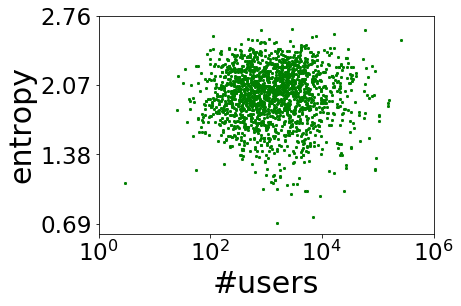

In [299]:
def plot_users_vs_entropy(X, Y, output_file_name):
    plt.clf()

    ax = plt.subplot(111)
    ax.scatter(X, Y, color="green", marker='x', s=5)
    ax.set_ylabel('entropy', fontsize=30)
    ax.tick_params(labelsize=23)
    ax.set_xlabel('#users', fontsize=30)
    ax.set_xscale('log')
    ax.set_yticks(np.arange(0.69, math.exp(1)+.1, .69))
    ax.set_xlim(1,1000000)
    plt.savefig(output_file_name, dpi=300, bbox_inches='tight')

plot_users_vs_entropy(X, Y, "../plots/plot_users_vs_entropy.svg")

In [430]:
#Correlation

np.corrcoef(X, Y)

array([[ 1.        , -0.01457834],
       [-0.01457834,  1.        ]])

In [291]:
sorted_ratios = sorted(ratios.items(), key=operator.itemgetter(1), reverse=True)

In [292]:
#Entropy/User

for i in range(10):
    proj = sorted_ratios[i][0]
    name = names[int(proj)]
    desc = descriptions[int(proj)]
    r = sorted_ratios[i][1]
    ent = entropy_per_project[proj] 
    usr = users_per_project[proj]
    
    print("#", i, ", project: ", name, ", entropy: ", ent, ", users: ", usr, ", entropy/user: ", r, "\
        , \ndescription: ", desc, "\n")    

# 0 , project:  Climber's Head (TowerClimb) , entropy:  1.0986122886681096 , users:  3 , entropy/user:  0.36620409622270317         , 
description:  These inconspicuous 4 pixels are actually the head of the protagonist from the roguelike platformer game "TowerClimb". 

# 1 , project:  Smiley Face , entropy:  2.1679025503594818 , users:  26 , entropy/user:  0.08338086732151853         , 
description:  A universal symbol of happiness rendered on a small scale for bite sized fun. 

# 2 , project:  The R , entropy:  1.8216729838184715 , users:  25 , entropy/user:  0.07286691935273887         , 
description:  The R of the sub r/The_R 

# 3 , project:  Italy heart , entropy:  2.0908155810619586 , users:  32 , entropy/user:  0.06533798690818621         , 
description:  A random heart or a symbol of cooperation between Scott Pilgrim and Italy? 

# 4 , project:  Make Trade Fair , entropy:  2.23330011555482 , users:  35 , entropy/user:  0.06380857473013772         , 
description:  An organizatio

In [293]:
for i in range(1,11):
    proj = sorted_ratios[-i][0]
    name = names[int(proj)]
    desc = descriptions[int(proj)]
    r = sorted_ratios[-i][1]
    ent = entropy_per_project[proj] 
    usr = users_per_project[proj]
    
    print("#", i, ", project: ", name, ", entropy: ", ent, ", users: ", usr, ", entropy/user: ", r, "\
        , \ndescription: ", desc, "\n")    

# 1 , project:  Rainbow Road , entropy:  2.5201075806834554 , users:  266766 , entropy/user:  9.446884463100453e-06         , 
description:  One of the first projects on r/place, and also one of the largest. It integrates itself with many other artworks. 

# 2 , project:  USA / Canvas Center , entropy:  1.9258022777284207 , users:  158121 , entropy/user:  1.2179294829456054e-05         , 
description:  The center of the canvas was a controversial and disputed part of r/place. It began to be filled with numerous randomly placed pixels. As organized groups began creating masterpieces, the center began a white void, part of r/erase. As the original (dark) Void began to eat the center of the canvas, the USA Flag began to take shape covering a branch from the void. The flag took over the white void and a few projects including a smiley and a tree. Then the void reappeared in place and with other people erased most of the flag as RainbowRoad expanded where the flag was. Ireland saw an opport

In [375]:
#Users vs. time per project

X = np.zeros(len(updates_per_project))
Y = np.zeros(len(updates_per_project))
ratios = {}
IDs = []

i = 0
for p in updates_per_project.keys():
    usr = users_per_project[p]
    t = times_per_project[p] / (1000 * 60 * 60)
    
    Y[i] = t
    X[i] = usr
    
    ratios[p] = t / usr
    
    IDs.append(names[int(p)])
    
    i = i + 1
    
IDs = np.array(list(IDs), dtype=object)

In [376]:
%matplotlib tk

cmap = plt.cm.RdYlGn
norm = plt.Normalize(1,4)

fig, ax = plt.subplots()
sc = ax.scatter(X, Y, color="green", marker='x', s=5)
ax.scatter(X, Y, color="green", marker='x', s=5)
ax.set_ylabel('times (hours)', fontsize=30)
ax.tick_params(labelsize=23)
ax.set_xlabel('#users', fontsize=30)
ax.set_xscale('log')
ax.set_ylim(0,100)
ax.set_xlim(1,1000000)
    
annot = ax.annotate("", xy=(0,0), xytext=(5,5),textcoords="offset points", size=14)
annot.set_visible(False)   

def update_annot(ind):
    pos = sc.get_offsets()[ind["ind"][0]]
    annot.xy = pos
    text = "{}".format("".join(IDs[ind["ind"]]))
    annot.set_text(text)
    
def hover(event):
    vis = annot.get_visible()
    if event.inaxes == ax:
        cont, ind = sc.contains(event)
        if cont:
            update_annot(ind)
            annot.set_visible(True)
            fig.canvas.draw_idle()
        else:
            if vis:
                annot.set_visible(False)
                fig.canvas.draw_idle()
    
fig.canvas.mpl_connect("motion_notify_event", hover)

5

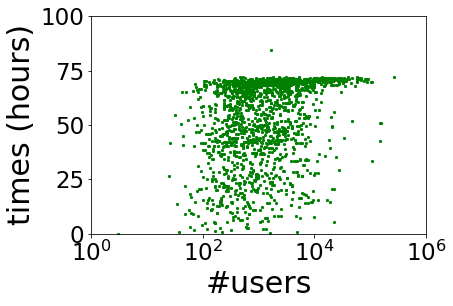

In [301]:
def plot_users_vs_times(X, Y, output_file_name):
    plt.clf()

    ax = plt.subplot(111)
    ax.scatter(X, Y, color="green", marker='x', s=5)
    ax.set_ylabel('times (hours)', fontsize=30)
    ax.tick_params(labelsize=23)
    ax.set_xlabel('#users', fontsize=30)
    ax.set_xscale('log')
    ax.set_ylim(0,100)
    ax.set_xlim(1,1000000)
    plt.savefig(output_file_name, dpi=300, bbox_inches='tight')

plot_users_vs_times(X, Y, "../plots/plot_users_vs_times.svg")

In [437]:
#Correlation

np.corrcoef(X, Y)

array([[1.        , 0.14488014],
       [0.14488014, 1.        ]])

In [304]:
sorted_ratios = sorted(ratios.items(), key=operator.itemgetter(1), reverse=True)

In [305]:
#Time/User

for i in range(10):
    proj = sorted_ratios[i][0]
    name = names[int(proj)]
    desc = descriptions[int(proj)]
    r = sorted_ratios[i][1]
    tm = times_per_project[proj] / (1000 * 60 * 60)
    usr = users_per_project[proj]
    
    print("#", i, ", project: ", name, ", time: ", tm, ", users: ", usr, ", time/user: ", r, "\
        , \ndescription: ", desc, "\n")    

# 0 , project:  Italy heart , time:  54.689166666666665 , users:  32 , time/user:  1.7090364583333333         , 
description:  A random heart or a symbol of cooperation between Scott Pilgrim and Italy? 

# 1 , project:  Smiley Face , time:  41.72138888888889 , users:  26 , time/user:  1.6046688034188035         , 
description:  A universal symbol of happiness rendered on a small scale for bite sized fun. 

# 2 , project:  Bread , time:  65.08055555555555 , users:  43 , time/user:  1.513501291989664         , 
description:  A loaf of Bread constructed by a few users of Anarchist subreddits to represent the ideas of Pyotr Kropotkin, Russian anarchist and author of the influential anarchist book, 'The Conquest of Bread'. Since this was a relatively late addition to the place, and is not a particularly obviously Leftist symbol, the Bread saw little vandalism and required no bots to maintain. 

# 3 , project:  Bread , time:  65.08055555555555 , users:  51 , time/user:  1.2760893246187361   

In [306]:
for i in range(1,11):
    proj = sorted_ratios[-i][0]
    name = names[int(proj)]
    desc = descriptions[int(proj)]
    r = sorted_ratios[-i][1]
    tm = times_per_project[proj] / (1000 * 60 * 60)
    usr = users_per_project[proj]
    
    print("#", i, ", project: ", name, ", time: ", tm, ", users: ", usr, ", time/user: ", r, "\
        , \ndescription: ", desc, "\n")    

# 1 , project:  Climber's Head (TowerClimb) , time:  0.0 , users:  3 , time/user:  0.0         , 
description:  These inconspicuous 4 pixels are actually the head of the protagonist from the roguelike platformer game "TowerClimb". 

# 2 , project:  The purple corner , time:  0.5097222222222222 , users:  4849 , time/user:  0.00010511903943539331         , 
description:  Originally a "colony" of the blue corner, a loss of interest among blue corner pixel-placers lead to the upper-left corner of the canvas being taken over by the faction that would eventually become /r/purplepixels. However, like all of the colour factions that dominated the early Place, the purple corner was eventually crowded out by pixel art. 

# 3 , project:  PINLAND , time:  0.30694444444444446 , users:  1589 , time/user:  0.00019316830990839803         , 
description:  It was very common for users to change these few pixels so the F turned into a P 

# 4 , project:  D.Va Bunny , time:  5.251666666666667 , users:  22

In [379]:
#Time vs. entropy per project

X = np.zeros(len(updates_per_project))
Y = np.zeros(len(updates_per_project))
ratios = {}
IDs = []

i = 0
for p in updates_per_project.keys():
    ent = entropy_per_project[p]
    t = times_per_project[p] / (1000 * 60 * 60)
    
    Y[i] = ent
    X[i] = t
    
    if t > 0:
        ratios[p] = ent / t
    
    IDs.append(names[int(p)])
    
    i = i + 1
    
IDs = np.array(list(IDs), dtype=object)

In [380]:
%matplotlib tk

cmap = plt.cm.RdYlGn
norm = plt.Normalize(1,4)

fig, ax = plt.subplots()
sc = ax.scatter(X, Y, color="green", marker='x', s=5)
ax.scatter(X, Y, color="green", marker='x', s=5)
ax.set_xlabel('times (hours)', fontsize=30)
ax.tick_params(labelsize=23)
ax.set_ylabel('entropy', fontsize=30)
ax.set_yticks(np.arange(0.69,math.exp(1)+.1, .69))
ax.set_xlim(0,100)
    
annot = ax.annotate("", xy=(0,0), xytext=(5,5),textcoords="offset points", size=14)
annot.set_visible(False)   

def update_annot(ind):
    pos = sc.get_offsets()[ind["ind"][0]]
    annot.xy = pos
    text = "{}".format("".join(IDs[ind["ind"]]))
    annot.set_text(text)
    
def hover(event):
    vis = annot.get_visible()
    if event.inaxes == ax:
        cont, ind = sc.contains(event)
        if cont:
            update_annot(ind)
            annot.set_visible(True)
            fig.canvas.draw_idle()
        else:
            if vis:
                annot.set_visible(False)
                fig.canvas.draw_idle()
    
fig.canvas.mpl_connect("motion_notify_event", hover)

5

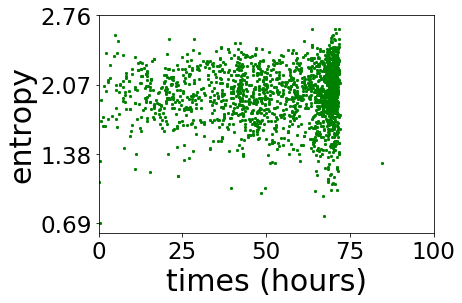

In [308]:
def plot_entropy_vs_times(X, Y, output_file_name):
    plt.clf()

    ax = plt.subplot(111)
    ax.scatter(X, Y, color="green", marker='x', s=5)
    ax.set_xlabel('times (hours)', fontsize=30)
    ax.tick_params(labelsize=23)
    ax.set_ylabel('entropy', fontsize=30)
    ax.set_yticks(np.arange(0.69,math.exp(1)+.1, .69))
    ax.set_xlim(0,100)
    plt.savefig(output_file_name, dpi=300, bbox_inches='tight')

plot_entropy_vs_times(X, Y, "plot_entropy_vs_times.svg")

In [309]:
#Correlation

np.corrcoef(X, Y)

array([[1.        , 0.02066956],
       [0.02066956, 1.        ]])

In [310]:
sorted_ratios = sorted(ratios.items(), key=operator.itemgetter(1), reverse=True)

In [311]:
#Entropy/Time

for i in range(10):
    proj = sorted_ratios[i][0]
    name = names[int(proj)]
    desc = descriptions[int(proj)]
    r = sorted_ratios[i][1]
    tm = times_per_project[proj] / (1000 * 60 * 60)
    ent = entropy_per_project[proj]
    
    print("#", i, ", project: ", name, ", entropy: ", ent, ", time: ", tm, ", entropy/time: ", r, "\
        , \ndescription: ", desc, "\n")    

# 0 , project:  Eightfold , entropy:  1.7075036453641854 , time:  0.6638888888888889 , entropy/time:  2.5719720181217856         , 
description:  What remains of Eightfold, a paper spider character from a webcomic called Paranatural. 

# 1 , project:  The purple corner , entropy:  1.302178642906814 , time:  0.5097222222222222 , entropy/time:  2.554682896165957         , 
description:  Originally a "colony" of the blue corner, a loss of interest among blue corner pixel-placers lead to the upper-left corner of the canvas being taken over by the faction that would eventually become /r/purplepixels. However, like all of the colour factions that dominated the early Place, the purple corner was eventually crowded out by pixel art. 

# 2 , project:  Gold Codfish , entropy:  1.9147854753595217 , time:  0.8355555555555556 , entropy/time:  2.2916315529568743         , 
description:  The /r/portugal equivalent of reddit gold. Given to topics and posts of high quality in the subreddit (mod flair) 

In [314]:
for i in range(1,11):
    proj = sorted_ratios[-i][0]
    name = names[int(proj)]
    desc = descriptions[int(proj)]
    r = sorted_ratios[-i][1]
    tm = times_per_project[proj] / (1000 * 60 * 60)
    ent = entropy_per_project[proj]
    
    print("#", i, ", project: ", name, ", entropy: ", ent, ", time: ", tm, ", entropy/time: ", r, "\
        , \ndescription: ", desc, "\n")    

# 1 , project:  (covered) 7-1 , entropy:  0.7545123567706904 , time:  67.4075 , entropy/time:  0.011193299807450067         , 
description:  The corner of the Brazil Flag that was vandalized over in over again in an attempt to shame Brazil for their 7-1 defeat against Germany in the 2014 world cup. Now all that remains is a single pixel of where the 7 starts 

# 2 , project:  Letter battle , entropy:  1.0174379097233763 , time:  71.06333333333333 , entropy/time:  0.014317340068343398         , 
description:  During the making of this, there was a lot of sabotage to the logo from peasants who can't stand the master race, and the FPS was changed a lot and started at 60FPS but exploded to a enormous number towards the end of R/place to show that PCMasterRace have no limitations.  

# 3 , project:  Hanzo Switch Pls , entropy:  0.962231222075264 , time:  67.06583333333333 , entropy/time:  0.014347562301846655         , 
description:  After initially writing "Switch" here, the words "Hanzo" 

In [3]:
min_time = 1490918688000
max_time = 1491238734000

n_vals = int((max_time-min_time) / (1000 * 60 * 60))
updates_per_time = np.zeros(n_vals+1)

with open("../data/sorted_tile_placements.csv",'r') as file:
    # Skip first line (header row)
    next(file, None)
    reader = csv.reader(file)
    for r in reader:
        ts = int(r[0])        
        t = int((ts-min_time) / (1000 * 60 * 60))
        updates_per_time[t] = updates_per_time[t] + 1

In [21]:
%matplotlib inline
def plot_updates_per_time(updates_per_time, output_file_name, plot_title):
    plt.clf()

    ax = plt.subplot(111)
    ax.plot(np.arange(updates_per_time.shape[0]), updates_per_time, color="black", linewidth=4)
    ax.set_ylabel('#updates', fontsize=30)
    ax.set_xlabel('time (hours)', fontsize=30)
    ax.tick_params(labelsize=23)
    ax.set_yticks(np.arange(0,np.max(updates_per_time), 100000))
    ax.set_title(plot_title)
    plt.savefig(output_file_name, dpi=300, bbox_inches='tight')


In [82]:
%matplotlib inline
def plot_updates_per_time_all_types(pixel, pixel_color, other, output_file_name):
    plt.clf()
    ax = plt.subplot(111)
    total = pixel+pixel_color+other
    ax.plot(np.arange(pixel.shape[0]), 100*pixel, color="green", linewidth=5, label="Final", linestyle='-')
    ax.plot(np.arange(pixel_color.shape[0]), 100*pixel_color, color="blue", linewidth=4, label="Match", linestyle='--')
    ax.plot(np.arange(other.shape[0]), 100*other, color="red", linewidth=3, label="Adv", linestyle=':')
        
    ax.set_ylabel('update (%)', fontsize=30)
    ax.set_xlabel('time (hours)', fontsize=30)
    ax.tick_params(labelsize=23)
    ax.set_xticks(np.arange(0,97, 24))
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2),
          fancybox=True, shadow=True, ncol=3, fontsize=15)
    ax.ticklabel_format(useOffset=False, style='plain')
    plt.savefig(output_file_name, dpi=300, bbox_inches='tight')


In [23]:
def generate_figures_time(hour_marks, picID):
    begin_time = 1490918688000
    
    if picID is None:
            data = extract_canvas_color('../data/sorted_tile_placements.csv', 0, 1000, 0, 1000,\
                            begin_time+1000*60*60*hour_marks)
    else:
            data = extract_project_color('../data/tile_placements_proj.csv', picID, 
                            begin_time+1000*60*60*hour_marks)
    
    for t in range(len(hour_marks)):
        tmp_file_name = "../plots/tmp_fig_"+str(t)+".png"
        draw_canvas(canvas_color_code_rgb(data[t]), tmp_file_name);

In [22]:
from canvas_vis import *
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)
from matplotlib.cbook import get_sample_data
import time
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.axes_divider import make_axes_area_auto_adjustable

%matplotlib inline
def plot_updates_per_time_with_figure(pixel, pixel_color, other, proj, hour_marks, up_line, zoom, output_file_name):
    plt.clf()
    ax = plt.subplot(111)
    total = pixel+pixel_color+other
    ax.plot(np.arange(pixel.shape[0]), 100*pixel, color="green", linewidth=5, label="Final", linestyle='-')
    ax.plot(np.arange(pixel_color.shape[0]), 100*pixel_color, color="blue", linewidth=4, label="Match", linestyle='--')
    ax.plot(np.arange(other.shape[0]), 100*other, color="red", linewidth=3, label="Adv", linestyle=':')
       
    for t in range(len(hour_marks)):
        tmp_file_name = "../plots/tmp_fig_"+str(t)+".png"
        arr_img = plt.imread(tmp_file_name, format='png')
        
        imagebox = OffsetImage(arr_img, zoom=zoom)
        imagebox.image.axes = ax
    
        ab = AnnotationBbox(imagebox, (hour_marks[t], up_line),
                        None,
                        xycoords='data',
                        pad=0.1)

        ax.add_artist(ab)
    
    ax.set_ylabel('update (%)', fontsize=20)
    ax.set_xlabel('time (hours)', fontsize=20)
    ax.tick_params(labelsize=18)
    ax.set_xlim(0, 110)

    ax.set_xticks(np.arange(0,95, 24))
    ax.set_ylim(0, 2.2)
    ax.set_yticks(np.arange(0,1.3, .4))
    
    ax.vlines(np.array(hour_marks),ymin=0,ymax=up_line,color='k', linestyle='--')
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2),
          fancybox=True, shadow=True, ncol=3, fontsize=15)
    ax.ticklabel_format(useOffset=False, style='plain')
    #ax.set_aspect(aspect=.2)
    
    plt.savefig(output_file_name, dpi=300, bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

<Figure size 7200x7200 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 7200x7200 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 7200x7200 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 7200x7200 with 0 Axes>

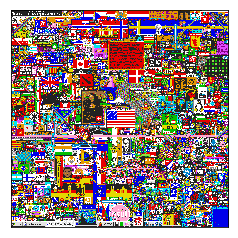

In [24]:
generate_figures_time(np.array([24, 48, 72, 96]), None)

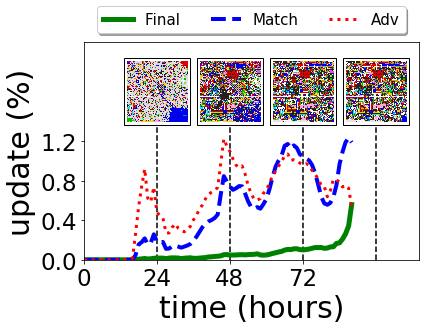

In [30]:
plot_updates_per_time_with_figure(total_tile_updates["final_updates"], total_tile_updates["agreeing_updates"],
    total_tile_updates["disagreeing_updates"], None, np.array([24, 48, 72, 96]), 1.7, 
    "../plots/plot_updates_time_total_fig.svg")

In [4]:
locations = store_locations("../data/atlas_filtered.json")

NameError: name 'unicode' is not defined

In [13]:
#Compute (and plot) different time series related to all projects
#final updates per hour, agreeing updates per hour, disagreeing updates per hour
min_time = 1490918688000
max_time = 1491238734000

n_vals = int((max_time-min_time) / (1000 * 60 * 60))
final_updates = np.zeros(n_vals+1)
updates_agree = np.zeros(n_vals+1)
updates_disagree = np.zeros(n_vals+1)

# Create a set to make sure the same update is not repeatedly counted
repeat_checker = set()

with open("../data/tile_placements_proj.csv",'r') as file:
    # Skip first line (header row)
    next(file, None)
    reader = csv.reader(file)
    for r in reader:
        ts = int(r[0])        
        x = int(r[2])
        y = int(r[3])
        if ( (ts, x, y) not in repeat_checker ):
            
            repeat_checker.add((ts, x, y))
            t = int((ts-min_time) / (1000 * 60 * 60))
            final_pixel = int(r[6])
            final_pixel_color = int(r[7])
            if final_pixel == 1:
                final_updates[t] = final_updates[t] + 1
            if final_pixel_color == 1:
                updates_agree[t] = updates_agree[t] + 1
            else:
                updates_disagree[t] = updates_disagree[t] + 1
    

In [79]:
# The total number of updates is equal to the number of lines in tile_placements.csv
# Subtract 1 for the header row
num_updates = len(repeat_checker)

"""
    Let q(t) the pixel probability (or pixel_color) at time t and r(t) be the probability of a disagreeing-pixel update. 
    Then the entropy is:

    -Sum_t q(t) log(q(t)) - Sum_t r(t) log(r(t))
"""

agreeing_entropy = np.zeros(n_vals + 1)
disagreeing_entropy = np.zeros(n_vals + 1)
total_entropy = 0
    
checksum = 0
    
for i in range(n_vals + 1):
    p1 = (updates_agree[i] / num_updates )
#     print(p1)
    p2 = (updates_disagree[i] / num_updates )
#     print(p2)
    if p1 != 0:
        agreeing_entropy[i] = -(p1 * math.log(p1))
    if p2 != 0: 
        disagreeing_entropy[i] = -(p2 * math.log(p2))
    
    total_entropy = total_entropy + agreeing_entropy[i] + disagreeing_entropy[i]
    
    checksum = checksum + p1 + p2
    
print(checksum)
print(total_entropy)

1.0000000000000002
4.844910821503593


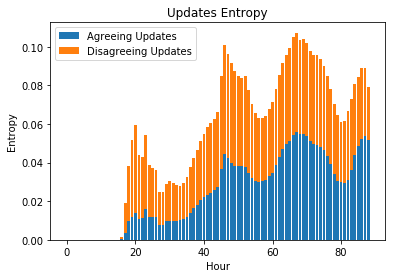

In [80]:
%matplotlib inline
# %matplotlib tk

# Graph the entropy bars on top of each other
plt.clf()
agree = plt.bar(range(n_vals + 1), agreeing_entropy, label = "Agreeing Updates")
disagree = plt.bar(range(n_vals + 1), disagreeing_entropy, bottom = agreeing_entropy, label = "Disagreeing Updates")
plt.xlabel('Hour')
plt.ylabel('Entropy')
plt.title("Updates Entropy")
plt.legend()
plt.show()


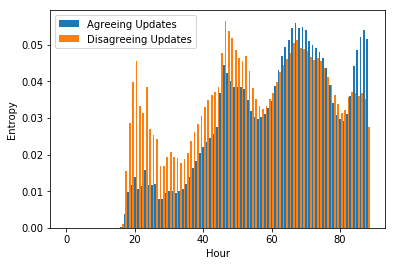

In [81]:


plt.clf()
# Graph the entropy bars side by side
width = 0.50

agree = plt.bar(range(n_vals + 1), agreeing_entropy, width = width, label = "Agreeing Updates")
disagree = plt.bar(np.array(range(n_vals + 1)) + width, disagreeing_entropy, width = width, label = "Disagreeing Updates")
plt.xlabel('Hour')
plt.ylabel('Entropy')
plt.legend()
plt.show()


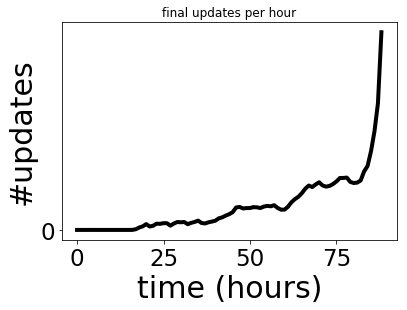

In [22]:
plot_updates_per_time(final_updates, "../plots/plot_final_updates_time.svg","final updates per hour")

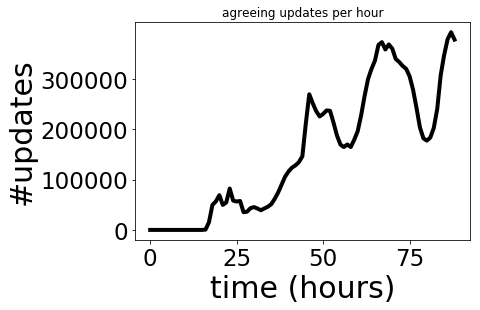

In [60]:
plot_updates_per_time(updates_agree, "../plots/plot_agreeing_updates_time.svg", "agreeing updates per hour")

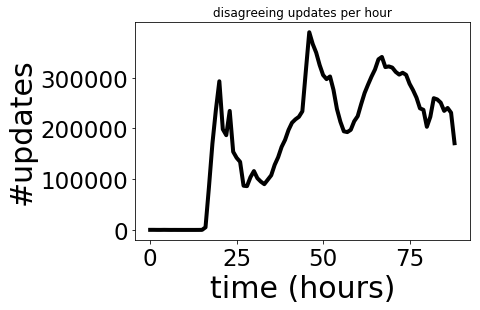

In [61]:
plot_updates_per_time(updates_disagree, "../plots/plot_disagreeing_updates_time.svg", "disagreeing updates per hour")

In [62]:
#Compute (and plot) different time series related to every single project 
#final updates per hour, agreeing updates per hour, disagreeing updates per hour
%matplotlib inline
def make_multiple_plots(final_updates, agreeing_updates, disagreeing_updates):
    
    fig, axs = plt.subplots(3,1,figsize=(30,30))
    ax1 = axs[0]
    ax1.plot(np.arange(final_updates.shape[0]), final_updates, color="black", linewidth=4)
    ax1.set_ylabel('#updates', fontsize=30)
    ax1.set_xlabel('time (hours)', fontsize=30)
    ax1.tick_params(labelsize=23)
    ax1.set_yticks(np.arange(0,np.max(final_updates), 100000))
    ax1.set_title("Final updates per hour")
    
    ax2 = axs[1]
    ax2.plot(np.arange(agreeing_updates.shape[0]), agreeing_updates, color="black", linewidth=4)
    ax2.set_ylabel('#updates', fontsize=30)
    ax2.set_xlabel('time (hours)', fontsize=30)
    ax2.tick_params(labelsize=23)
    ax2.set_yticks(np.arange(0,np.max(agreeing_updates), 100000))
    ax2.set_title("agreeing updates per hour")
    
    ax3 = axs[2]
    ax3.plot(np.arange(disagreeing_updates.shape[0]), disagreeing_updates, color="black", linewidth=4)
    ax3.set_ylabel('#updates', fontsize=30)
    ax3.set_xlabel('time (hours)', fontsize=30)
    ax3.tick_params(labelsize=23)
    ax3.set_yticks(np.arange(0,np.max(disagreeing_updates), 100000))
    ax3.set_title("disagreeing updates per hour")
    
    plt.show()


In [12]:
#Parse data to separate update types for each project
min_time = 1490918688000
max_time = 1491238734000
n_vals = int((max_time-min_time) / (1000 * 60 * 60))
tile_updates = dict()
total_tile_updates = {"final_updates":np.zeros(n_vals+1), 
    "agreeing_updates":np.zeros(n_vals+1), 
    "disagreeing_updates":np.zeros(n_vals+1)}

with open("../data/tile_placements_proj.csv",'r') as file:
    # Skip first line (header row)
    next(file, None)
    reader = csv.reader(file)
    for r in reader:
        picID = int(r[5])
        ts = int(r[0])        
        t = int((ts-min_time) / (1000 * 60 * 60))
        final_pixel = int(r[6])
        final_pixel_color = int(r[7])
        if picID not in tile_updates:
            tile_updates[picID] = {"final_updates":np.zeros(n_vals+1), 
                                   "agreeing_updates":np.zeros(n_vals+1), 
                                   "disagreeing_updates":np.zeros(n_vals+1)}
        if final_pixel == 1:
            tile_updates[picID]["final_updates"][t] = tile_updates[picID]["final_updates"][t] + 1
            total_tile_updates["final_updates"][t] = total_tile_updates["final_updates"][t] + 1
        if final_pixel_color == 1:
            tile_updates[picID]["agreeing_updates"][t] = tile_updates[picID]["agreeing_updates"][t] + 1
            total_tile_updates["agreeing_updates"][t] = total_tile_updates["agreeing_updates"][t] + 1
        else:
            tile_updates[picID]["disagreeing_updates"][t] = tile_updates[picID]["disagreeing_updates"][t] + 1     
            total_tile_updates["disagreeing_updates"][t] = total_tile_updates["disagreeing_updates"][t] + 1

for picID in tile_updates:
    s = np.sum(tile_updates[picID]["final_updates"]) + np.sum(tile_updates[picID]["agreeing_updates"])\
        + np.sum(tile_updates[picID]["disagreeing_updates"])
    tile_updates[picID]["final_updates"] = tile_updates[picID]["final_updates"] / s
    
    tile_updates[picID]["agreeing_updates"] = tile_updates[picID]["agreeing_updates"] / s
    
    tile_updates[picID]["disagreeing_updates"] = tile_updates[picID]["disagreeing_updates"] / s
    
s = np.sum(total_tile_updates["final_updates"]) + np.sum(total_tile_updates["agreeing_updates"])\
        + np.sum(total_tile_updates["disagreeing_updates"])
total_tile_updates["final_updates"] = total_tile_updates["final_updates"] / s
total_tile_updates["agreeing_updates"] = total_tile_updates["agreeing_updates"] / s
total_tile_updates["disagreeing_updates"] = total_tile_updates["disagreeing_updates"] / s

In [54]:
#plot three graphs for a single project
def make_updates_per_time_plot(picID):
    make_multiple_plots(tile_updates[picID]["final_updates"], tile_updates[picID]["agreeing_updates"], tile_updates[picID]["disagreeing_updates"])
    

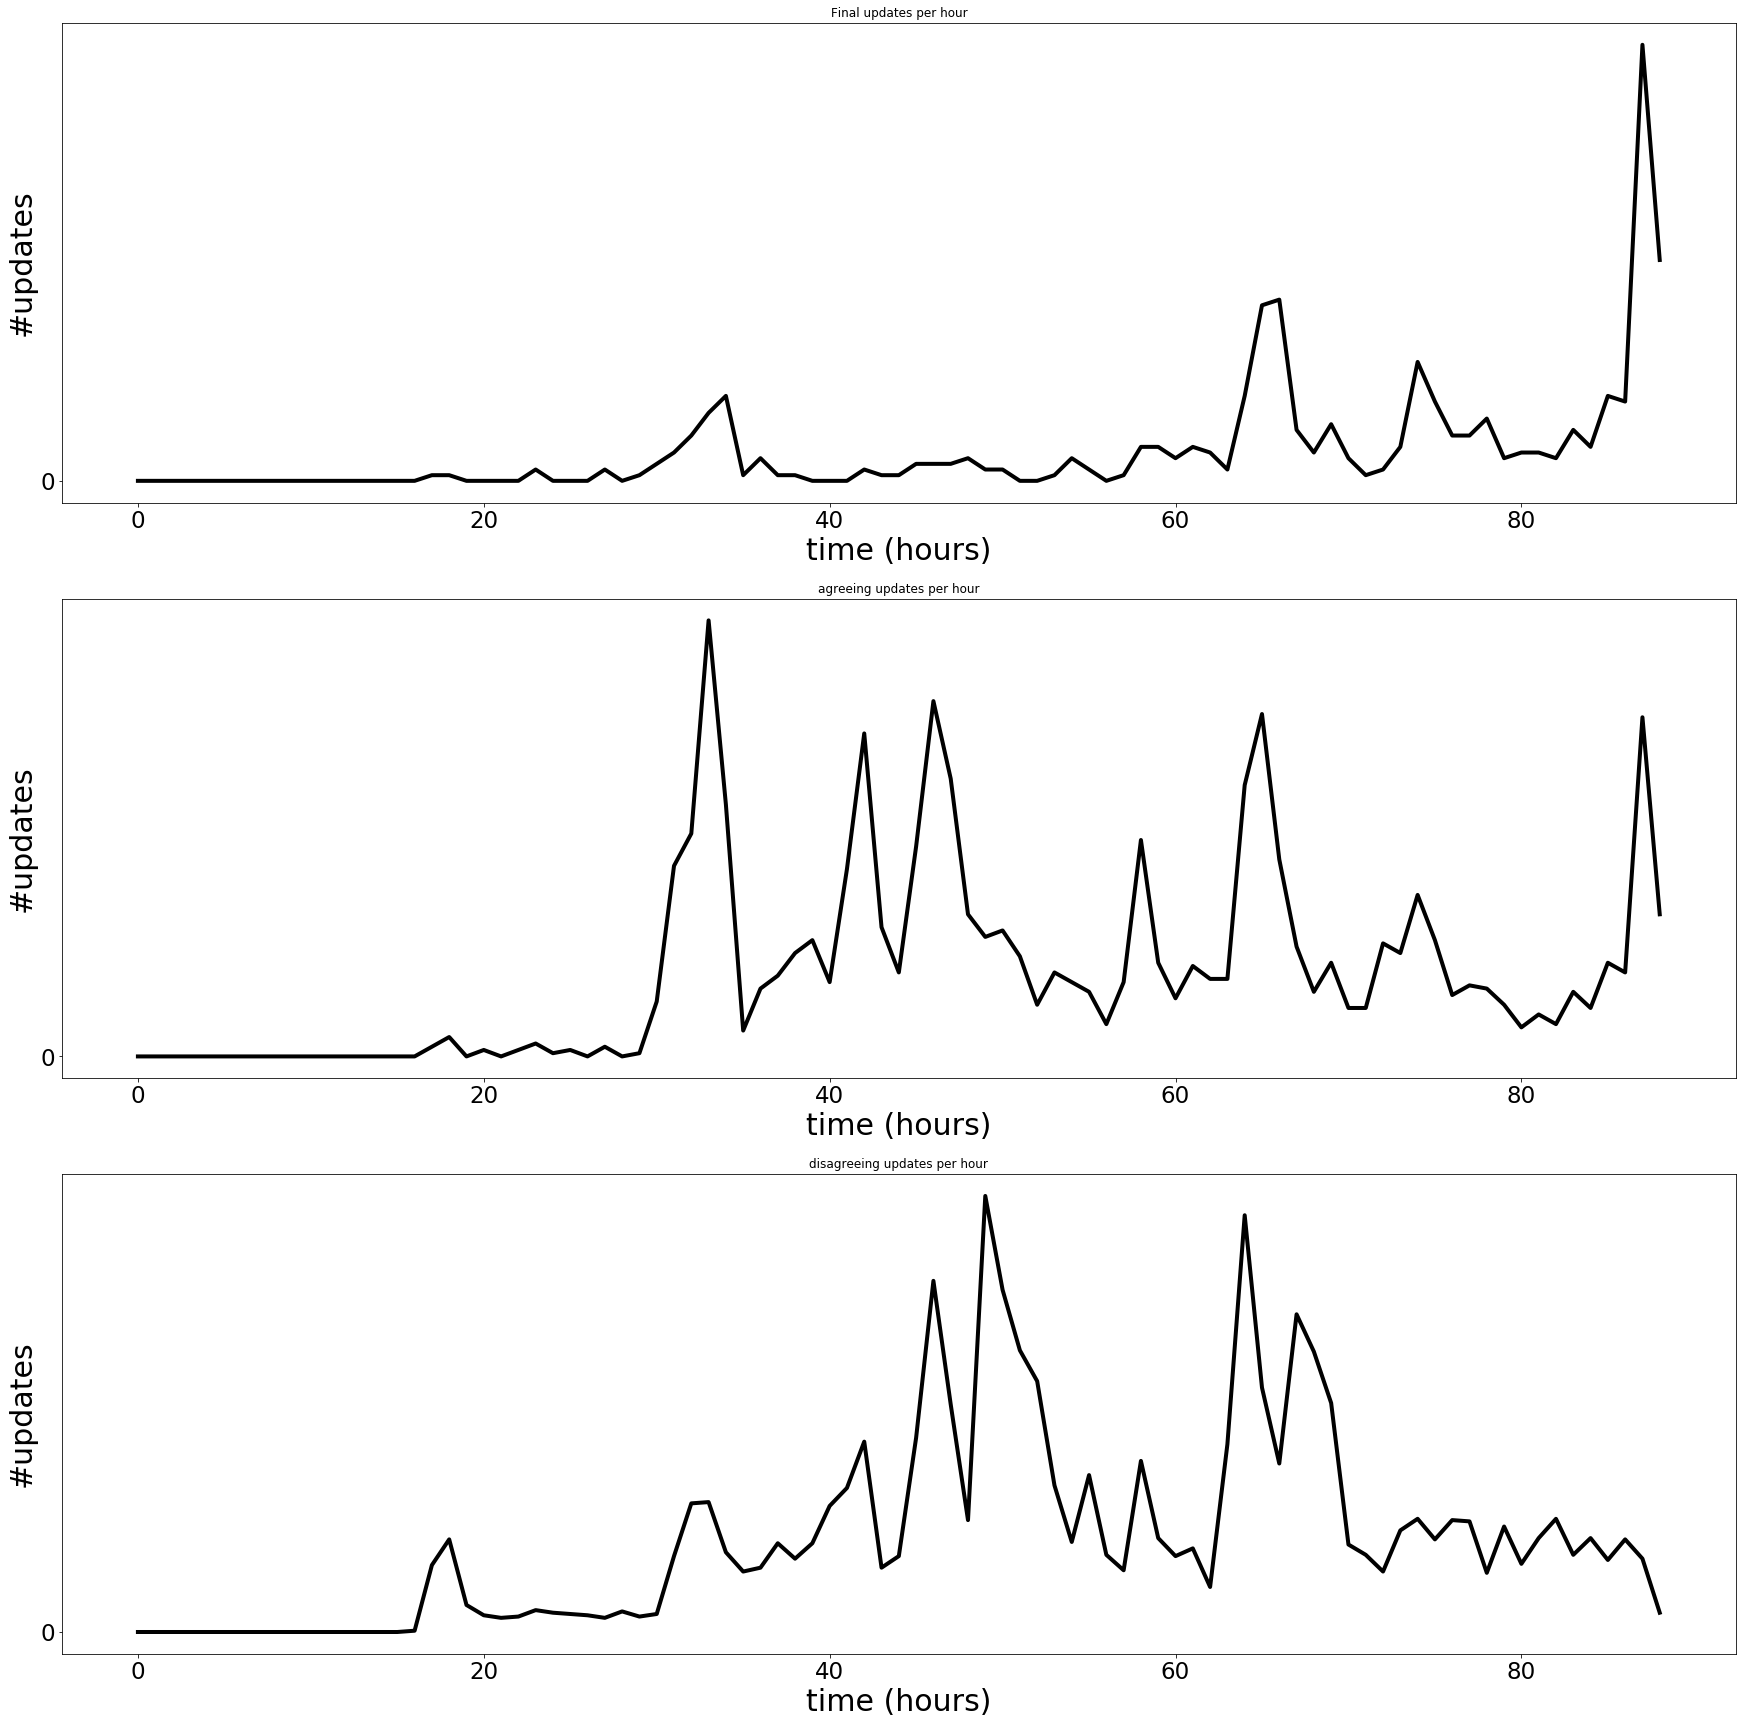

In [57]:
#Testing making muptiple plots on Rainbow Road
make_updates_per_time_plot(191)

In [18]:
%matplotlib tk

cmap = plt.cm.RdYlGn
norm = plt.Normalize(1,4)

pixel = total_tile_updates["final_updates"]

pixel_color = total_tile_updates["agreeing_updates"]

other = total_tile_updates["disagreeing_updates"]

fig,ax = plt.subplots()
total = pixel+pixel_color+other
line1, = ax.plot(np.arange(pixel.shape[0]), 100*pixel, color="green", linewidth=5, label="Final", linestyle='-')
line2, = ax.plot(np.arange(pixel_color.shape[0]), 100*pixel_color, color="blue", linewidth=4, label="Match", linestyle='--')
line3, = ax.plot(np.arange(other.shape[0]), 100*other, color="red", linewidth=3, label="Adv", linestyle=':')
        
ax.set_ylabel('update (%)', fontsize=30)
ax.set_xlabel('time (hours)', fontsize=30)
ax.tick_params(labelsize=23)
ax.set_xticks(np.arange(0,97, 24))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2),
          fancybox=True, shadow=True, ncol=3, fontsize=15)
ax.ticklabel_format(useOffset=False, style='plain')
    
annot = ax.annotate("", xy=(0,0), xytext=(5,5),textcoords="offset points", size=14)
annot.set_visible(False)   

def update_annot(ind, line):
    x,y = line.get_data()
    annot.xy = (x[ind["ind"][0]], y[ind["ind"][0]])
    text = "{}, {}".format(str(annot.xy[0]), 
                           str(np.around(annot.xy[1], decimals=2)))
    annot.set_text(text)

def hover(event):
    vis = annot.get_visible()
    if event.inaxes == ax:
        cont, ind = line1.contains(event)
        if cont:
            update_annot(ind, line1)
            annot.set_visible(True)
            fig.canvas.draw_idle()
        else:
            cont, ind = line2.contains(event)
            
            if cont:
                update_annot(ind, line2)
                annot.set_visible(True)
                fig.canvas.draw_idle()
            else:
                cont, ind = line3.contains(event)
            
                if cont:
                    update_annot(ind, line3)
                    annot.set_visible(True)
                    fig.canvas.draw_idle()
                else:
                    if vis:
                        annot.set_visible(False)
                    fig.canvas.draw_idle()

fig.canvas.mpl_connect("motion_notify_event", hover)

5

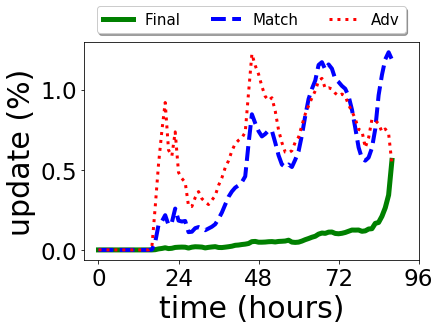

In [83]:
plot_updates_per_time_all_types(total_tile_updates["final_updates"], total_tile_updates["agreeing_updates"],
    total_tile_updates["disagreeing_updates"], "../plots/plot_updates_time_total.svg")

In [11]:
picID = 286
plot_updates_per_time_all_types(tile_updates[picID]["final_updates"], tile_updates[picID]["agreeing_updates"],
    tile_updates[picID]["disagreeing_updates"], "../plots/plot_updates_time_286.svg")

NameError: name 'plot_updates_per_time_all_types' is not defined

<Figure size 432x288 with 0 Axes>

<Figure size 7200x7200 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 7200x7200 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 7200x7200 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 7200x7200 with 0 Axes>

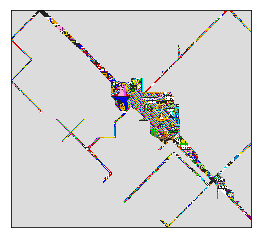

In [7]:
generate_figures_time(np.array([24, 48, 72, 96]), 286)

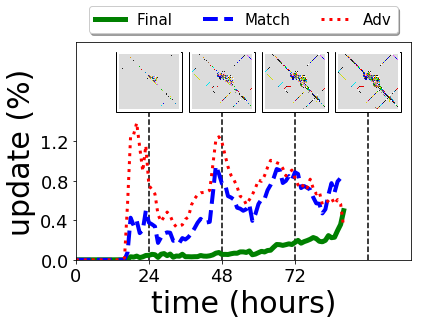

In [21]:
picID = 286

plot_updates_per_time_with_figure(tile_updates[picID]["final_updates"], tile_updates[picID]["agreeing_updates"],
    tile_updates[picID]["disagreeing_updates"], picID, np.array([24, 48, 72, 96]), 1.8, 0.045, 
    "../plots/plot_updates_time_286_fig.svg")

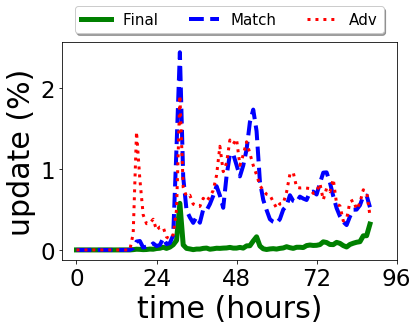

In [85]:
picID = 179
plot_updates_per_time_all_types(tile_updates[picID]["final_updates"], tile_updates[picID]["agreeing_updates"],
    tile_updates[picID]["disagreeing_updates"], "../plots/plot_updates_time_179.svg")

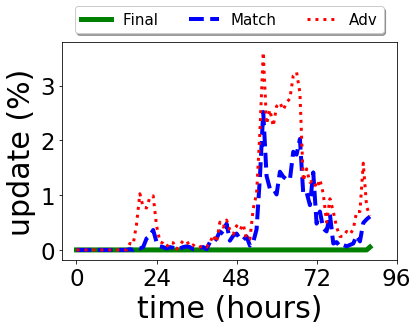

In [86]:
picID = 1493
plot_updates_per_time_all_types(tile_updates[picID]["final_updates"], tile_updates[picID]["agreeing_updates"],
    tile_updates[picID]["disagreeing_updates"], "../plots/plot_updates_time_1493.svg")

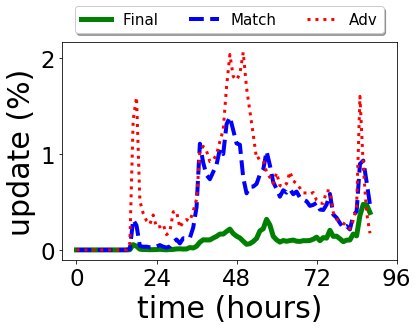

In [87]:
picID = 2
plot_updates_per_time_all_types(tile_updates[picID]["final_updates"], tile_updates[picID]["agreeing_updates"],
    tile_updates[picID]["disagreeing_updates"], "../plots/plot_updates_time_2.svg")

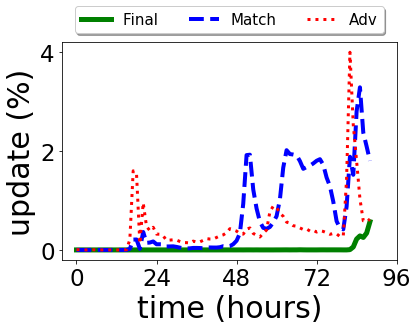

In [88]:
picID = 42
plot_updates_per_time_all_types(tile_updates[picID]["final_updates"], tile_updates[picID]["agreeing_updates"],
    tile_updates[picID]["disagreeing_updates"], "../plots/plot_updates_time_42.svg")

TODOS:

1 - Check project matching one last time, can we improve the borders? Example: 4-pixel project (ask Daniel) (DONE).

---

2 - Use new project files to generate these results (DONE).

3 - Push some of this code to a python module to make things cleaner (except plotting or printing results) (PARTIALLY DONE).

4 - Check entropy computation, use only final updates, add results for denoised versions too (DONE).

5 - Regenerate most of the results using agreeing rather than final pixels (DONE).

---

6 - Add update entropy results to this notebook (DONE).

7 - Add box density results to this notebook.

8 - Add user distance distributions to this notebook

---

9 - For the first set of plots (rank) add possibility of drawing project figures on the plot (can be chosen manually, via project ID). (GAVE UP)
https://stackoverflow.com/questions/3765056/combine-picture-and-plot-with-python-matplotlib

10 - Same as before for scatter plots. 

11 - For the last set of plots, add possibility of visualizing the state of the project at some handpicked timestamps. Might need to first do an iterative version (like for scatter plots) to pick the interesting states. (DONE)

---

11 - Create different notebook that generates the data used in this notebook (calling the functions that are implemented in Python_code). Add comments on file format (what is on each column). Add instructions about how to download the datasets that we have used (atlas and tile_updates) to replicate everything. (DONE)